In [1]:
import os
import dill
import random
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import sentence_bleu as bleu
from nltk.translate.bleu_score import SmoothingFunction

from utils import *
from seq2seq_data_loader import *

SMOOTH = SmoothingFunction()

In [2]:
loader = Seq2SeqDataLoader('mscoco/')
indexer, trainPairs, trainLens, testPairs, testLens = loader.load(specialTokenList=['EOS','SOS','PAD','UNK'])

... loading training data.
... loading test data.
Done!



In [3]:
%%time

glovePath = "glove_embeddings/glove.6B.300d.txt"
embeddings = np.zeros((indexer.size,300)) 
word2embedding = {}
count = 0
print "Reading embeddings ..."
with open(glovePath, 'r') as f:
    for line in f:
        count += 1
        line = line.split()
        word = line[0]
        embedding = np.array(line[1:], dtype=float)
        word2embedding[word] = embedding
        if count%10000==0:
            print '... processed %d lines.' % count
print "\nLoading embeddings to matrix ..."
oovSize = 0
for i in range(indexer.size): 
    word = indexer.get_word(i)
    if word in word2embedding:
        embeddings[i] = word2embedding[word]
    else:
        embeddings[i] = np.zeros(300)
        oovSize += 1
print "Done (#oov = %d)" % oovSize
del word2embedding

Reading embeddings ...
... processed 10000 lines.
... processed 20000 lines.
... processed 30000 lines.
... processed 40000 lines.
... processed 50000 lines.
... processed 60000 lines.
... processed 70000 lines.
... processed 80000 lines.
... processed 90000 lines.
... processed 100000 lines.
... processed 110000 lines.
... processed 120000 lines.
... processed 130000 lines.
... processed 140000 lines.
... processed 150000 lines.
... processed 160000 lines.
... processed 170000 lines.
... processed 180000 lines.
... processed 190000 lines.
... processed 200000 lines.
... processed 210000 lines.
... processed 220000 lines.
... processed 230000 lines.
... processed 240000 lines.
... processed 250000 lines.
... processed 260000 lines.
... processed 270000 lines.
... processed 280000 lines.
... processed 290000 lines.
... processed 300000 lines.
... processed 310000 lines.
... processed 320000 lines.
... processed 330000 lines.
... processed 340000 lines.
... processed 350000 lines.
... pr

In [128]:
# NB: shorthand shape annotation. 
#   `mt` = max-time/sequence-length; 
#   `bc` = batch-size; 
#   `emb` = embedding-size;
#   `h` = hidden-size;
#   `n_layer`, `n_dir`: #layers, #directions.

DOALL = None

class Encoder(nn.Module):
    """GRU encoder"""
    
    def __init__(self, inputSize, embeddingSize, hiddenSize, 
                 nLayers=2, dropout=0.1, bidirectional=True, gloveInit=np.array([])):
        """
        
        Args:
            inputSize: vocabulary size.
            embeddingSize: size of word embedding.
            hiddenSize: size of RNN hidden state.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            bidirectional: boolean.
            gloveInit: numpy.ndarray. Default is empty.
        """
        super(Encoder, self).__init__()
        # save params
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.embeddingSize = embeddingSize
        self.gloveInit = gloveInit
        self.nLayers = nLayers
        self.dropout = dropout
        self.bidirectional = bidirectional
        # build arc
        if len(self.gloveInit)>0:
            assert len(self.gloveInit)==self.inputSize
            self.embeddingSize = self.gloveInit.shape[1]
            self.embeddings = nn.Embedding(self.inputSize, self.embeddingSize)
            self.embeddings.weight.data.copy_(torch.from_numpy(self.gloveInit))
            del self.gloveInit
        else:
            self.embeddings = nn.Embedding(self.inputSize, self.embeddingSize)
        self.gru = nn.GRU(self.embeddingSize, self.hiddenSize, 
                          num_layers=self.nLayers, dropout=self.dropout, bidirectional=self.bidirectional)
    
    def forward(self, batchInput, batchLen, hidden=None):
        """
        
        Args:
            batchInputs: shape = <max-time(enc),batch-size>.
            batchLen: shape = <batch-size,>.
            hidden: input hidden state (initialized as None).
        """
        # bi: <mt-enc,bc>
        # bl: <bc,>
        embedded = self.embeddings(batchInput)
            # lookup: <mt-enc,bc> -> <mt-enc,bc,emb>
        packedInput = torch.nn.utils.rnn.pack_padded_sequence(embedded, batchLen)
            # 'packed' has a 'data' and a 'batch_sizes' field.
            #   'data' is a <sum(len),emb> matrix (len is real lengths, not padded).
            #   'batch_sizes' has the number of non-zero batches at each time-step.
            # e.g. for this 'inputs'
            #    2     1     3     0     2
            #    6     8     1     6     2
            #    0     7     0     8     8
            #    6     4     2     1     1
            #    1     8     1     1     1
            #    6     1     1     1     1
            #    0     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1  
            # 'data' = 22 = 7+5+4+3+3 (1's are pads corresponding to 'EOS').
            # 'batch_sizes' = [5, 5, 5, 3, 2, 1, 1].
        packedOutput, hidden = self.gru(packedInput, hidden)
            # packedOutput: <sum(bl),h*n_dir>; hidden: <n_layer*n_dir,bc,h>
        batchOutput, batchLen = torch.nn.utils.rnn.pad_packed_sequence(packedOutput)
            # batchOutput: <mt-enc,bc,h*n_dir>
            # batchLen: <bc,>      
        if self.bidirectional:
            batchOutput = torch.cat((batchOutput[:,:,:self.hiddenSize],
                                     batchOutput[:,:,self.hiddenSize:]),dim=-1)
                # <mt-enc,bc,h> cat <mt-enc,bc,h> -> <mt-enc,bc,h*n_dir=2h>
            hidden = torch.cat((hidden[:self.nLayers,:,:],
                                hidden[self.nLayers:,:,:]),dim=-1)
                # <n_layer,bc,h> cat <n_layer,bc,h> -> <n_layer,bc,h*n_dir=2h>
        return batchOutput, hidden
            # batchOutput: <mt-enc,bc,h*n_dir=2h>
            # hidden: <n_layer,bc,h*n_dir=2h>

class Attention(nn.Module):
    """Attention layer. https://github.com/tensorflow/nmt"""
    # Source: https://github.com/tensorflow/nmt
    
    def __init__(self, hiddenSize, attentionType='bahdanau'):
        """
        
        Args:
            hiddenSize: hidden size of the decoder.
            attentionType: `bahdanau` or `luong`.
        """
        super(Attention, self).__init__()
        # save params
        self.hiddenSize = hiddenSize
        self.attentionType = attentionType
        # layers for Bahdanau
        self.encoderLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        self.decoderLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        self.tanh = nn.Tanh()
        self.v = nn.Parameter(torch.rand(self.hiddenSize,1))
        # layers for Luong
        self.biLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        # general layer
        self.linear = nn.Linear(self.hiddenSize*2, self.hiddenSize)
    
    def bahdanau_score(self, encoderOutput, decoderHidden):
        """Bahdanau et al. (2015).
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            The `score` as the second in Eq.4 in the nmt tutorial.
        """
        # eo: <bc,mt-enc,h> =here= <bc,mt-enc,h>
        # dh: <bc,n_layer,h> =here= <bc,1,h>        
        return torch.matmul(self.tanh(self.encoderLinear(encoderOutput)+\
                                      self.decoderLinear(decoderHidden)),self.v).transpose(1,2)
            # op1. enc-o -> <bc,mt-enc,h>; dec-h -> <bc,1,h>; add -> <bc,mt-enc,h>
            # op2. tanh, shapes retain
            # op3. <bc,mt-enc,h> x <h,1> -> <bc,mt-enc,1>
            # op4. <bc,mt-enc,1> -> <bc,1,mt-enc> (convenient weighted-sum later)
    
    def luong_score(self, encoderOutput, decoderHidden):
        """Luong et al. (2016), `Global attention`.
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            The `score` as the first in Eq.4 in the nmt tutorial.        
        """
        # eo: <bc,mt-enc,h> =here= <bc,mt-enc,h>
        # dh: <bc,n_layer,h> =here= <bc,1,h> 
        return torch.bmm(self.biLinear(encoderOutput), decoderHidden.transpose(1,2)).transpose(1,2)
            # op1. linear on encoderOutput: <bc,mt-enc,h> -> <bc,mt-enc,h>
            # op2. decoderHidden transpose for bmm: <bc,1,h> -> <bc,h,1>
            # op3. bmm: <bc,mt-enc,h> x <bc,h,1> -> <bc,mt-enc,1>
            # op4. <bc,mt-enc,1> -> <bc,1,mt-enc> (convenient weighted-sum later)
    
    def score(self, encoderOutput, decoderHidden, attentionType):
        """Attention score by type.
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
            attentionType: `bahdanau` or `luong`.
        Returns:
            Score of chosen type.
        """
        assert attentionType in ['bahdanau','luong']
        if attentionType=='bahdanau':
            return self.bahdanau_score(encoderOutput, decoderHidden)
        return self.luong_score(encoderOutput, decoderHidden)
        
    def forward(self, encoderOutput, decoderHidden):
        """
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            a batch of attention vectors (as per Eq.3 in the nmt tutorial). 
        """
        # eo: <mt-enc,bc,h> =here= <mt-enc,bc,h>
        # dh: <n_layer,bc,h> =here= <1,bc,h>
        encoderOutput = encoderOutput.transpose(0,1) # <bc,mt-enc,h>
        decoderHidden = decoderHidden.transpose(0,1) # <bc,1,h>
        attentionWeights = F.softmax(self.score(encoderOutput, decoderHidden, self.attentionType),dim=-1)
            # <bc,1,mt-enc>, where sum by mt-end = 1.
        context = torch.bmm(attentionWeights, encoderOutput).squeeze()
            # op1. batch matmul: <bc,1,mt-enc> x <bc,mt-enc,h> -> <bc,1,h>
            # op2. <bc,1,h> -> <bc,h>
        return self.tanh(self.linear(torch.cat((context,decoderHidden.squeeze()),dim=-1))), \
               attentionWeights.squeeze()
            # return arg1
            #   op1. decoderHidden squeeze: <bc,1,h> -> <bc,h>
            #   op2. concat: <bc,h> cat <bc,h> -> <bc,2h>
            #   op3. final linear layer: <bc,2h> -> <bc,h>
            #   op4. final nonlinear: dim retain
            # return arg2
            #   <bc,mt-enc> attention matrix for visualization

class AttentionDecoder(nn.Module):
    
    def __init__(self, outputSize, embeddingSize, hiddenSize, attentionType='bahdanau',
                 nLayers=2, dropout=0.1, residual=True, gloveInit=np.array([])):
        """
        
        Args:
            outputSize: vocabulary size.
            embeddingSize: size of word embedding.
            hiddenSize: GRU hidden state size.
            attentionType: `bahdanau` or `luong`.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            residual: boolean, whether establish residual link (to top layer) or not.
            gloveInit: numpy.ndarray. Default is empty.
        """        
        # NB: hiddenSize should double if the encoder is bidirectional.
        super(AttentionDecoder, self).__init__()
        # save params
        self.outputSize = outputSize
        self.embeddingSize = embeddingSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.dropout = dropout
        self.residual = residual
        self.gloveInit = gloveInit
        # layers
        if len(self.gloveInit)>0:
            assert len(self.gloveInit)==self.outputSize
            self.embeddingSize = self.gloveInit.shape[1]
            self.embeddings = nn.Embedding(self.outputSize, self.embeddingSize)
            self.embeddings.weight.data.copy_(torch.from_numpy(self.gloveInit))
            del self.gloveInit
        else:
            self.embeddings = nn.Embedding(self.outputSize, self.embeddingSize)
        self.gru = nn.GRU(self.embeddingSize, self.hiddenSize, num_layers=self.nLayers, dropout=self.dropout)
        self.residualLinear = nn.Linear(self.embeddingSize, self.hiddenSize)
        self.attention = Attention(self.hiddenSize, attentionType).cuda()
        self.linear = nn.Linear(self.hiddenSize, self.outputSize) 
        self.tanh = nn.Tanh()
        self.logSoftmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, batchSingleInput, encoderOutput, prevHidden):
        # bsi: <bc,>
        # eo: <mt-enc,bc,h> =here= <mt-enc,bc,h>
        # ph: <n_layer,bc,h> =here= <1,bc,h>
        embedded = self.embeddings(batchSingleInput).unsqueeze(0)
            # op1. lookup: <bc,> -> <bc,emb>
            # op2. conform to GRU input format: <mt=1,bc,emb>
        batchSingleOutput, hidden = self.gru(embedded, prevHidden)
            # batchSingleOutput: <mt=1,bc,h>
            # hidden: <n_layer,bc,h>
        if self.residual:
            hidden = hidden + self.residualLinear(embedded)
                # op1. map input to correct space (in last dim): emb -> h
                # op2. broadcase elemwise addition
                #   <n_layer,bc,h> + <1,bc,h> = <n_layer,bc,h>
        batchAttentionVector, attentionWeights = self.attention(encoderOutput, 
                                                                hidden[-1].unsqueeze(0))
            # batchAttentionVector: <bc,2h>
            # attentionWeights: <bc,mt-enc>
            # NB: for hidden we only take the state from the last layer
        batchSingleOutput = self.logSoftmax(self.linear(batchAttentionVector))
            # op1. linear: <bc,h> -> <bc,vocab>
            # op2. log-softmax over vocab
        return batchSingleOutput, hidden, attentionWeights
            # batchSingleOutput: <bc,vocab>
            # hidden: <1,bc,h>
            # attentionWeights: <bc,mt-enc>
            
def batch_beam_decode(decoderOutputAll, k=3):
    # doall: <bc,mt-dec,vocab>, numpy.ndarray
    bc,mt,vocab = decoderOutputAll.shape
    batchSequences = [[[list(), 1.0]] for _ in range(bc)]
        # a batch of starting <sequence,score-so-far> tuples.
    for bc_id in range(bc):
        for row in decoderOutputAll[bc_id]: # each row: <vocab,>, mt rows.
            allCandidates = list()
            for i in range(len(batchSequences[bc_id])): # process each item on the beam.
                seq, score = batchSequences[bc_id][i]
                for j in range(len(row)): # process each word.
                    candidate = [seq+[j], score+row[j]]
                        # append word index to sequence, add to score-so-far.
                    allCandidates.append(candidate)
            ordered = sorted(allCandidates, key=lambda tup:tup[1], reverse=True)
            batchSequences[bc_id] = ordered[:k]
    results = np.array([[batchSequences[bc_id][k_id][0] for k_id in range(k)] for bc_id in range(bc)])
    return results


class Seq2Seq:
    
    def __init__(self, indexer, trainPairs, trainLens, testPairs, testLens,
                 attentionType='luong',
                 batchSize=128, embeddingSize=300, hiddenSize=100,
                 beamSize=2,
                 nLayers=2, dropout=0.1, residual=True, bidirectional=True,
                 lr=1e-4, enforcingRatio=0.5, clip=10.0,
                 gloveInit=np.array([]),
                 resultSavePath='mscoco/results.txt'):
        self.indexer = indexer
        self.trainIter = DataIterator(indexer, trainPairs, trainLens)
        self.testIter = DataIterator(indexer, testPairs, testLens)
        self.attentionType=attentionType
        self.batchSize = batchSize
        self.embeddingSize = embeddingSize
        self.hiddenSize = hiddenSize
        self.beamSize=beamSize
        self.nLayers=nLayers
        self.dropout=dropout
        self.residual=residual
        self.bidirectional=bidirectional
        self.lr = lr
        self.enforcingRatio = enforcingRatio
        self.clip = clip
        self.gloveInit = gloveInit
        self.resultSavePath = resultSavePath
        self._build_model()
    
    def _build_model(self):
        self.encoder = Encoder(self.indexer.size, self.embeddingSize, self.hiddenSize,
                               self.nLayers, self.dropout, self.bidirectional, self.gloveInit).cuda()
        self.decoder = AttentionDecoder(self.indexer.size, self.embeddingSize,
                                        self.hiddenSize*2 if self.bidirectional else self.hiddenSize,
                                        self.attentionType, self.nLayers, self.dropout, self.residual,
                                        self.gloveInit).cuda()
        del self.gloveInit
        self.encoderOptim = optim.Adam(self.encoder.parameters(), self.lr)
        self.decoderOptim = optim.Adam(self.decoder.parameters(), self.lr)
        self.criterion = nn.NLLLoss()

    def _model_config(self):
        return 'Vocab Size = ' + str(self.indexer.size) + '\n' + \
               'Train/Test Size = ' + str(self.trainIter.size)+'/'+str(self.testIter.size) + '\n' + \
               'AttentionType = ' + str(self.attentionType) + '\n' + \
               'batchSize = ' + str(self.batchSize) + '\n' + \
               'embeddingSize = ' + str(self.embeddingSize) + '; hiddenSize = ' + str(self.hiddenSize) + '\n' + \
               'nLayers = ' + str(self.nLayers) + '; dropout = ' + str(self.dropout) + '\n' + \
               'residual = ' + str(self.residual) + '; bidirectional = ' + str(self.bidirectional) + '\n' + \
               'learning rate = ' + str(self.lr) + '\n' + \
               'teacher enforce ratio = ' + str(self.enforcingRatio) + '; clip = ' + str(self.clip) + '\n\n'
    
    def _train_step(self):
        """One step of training."""
        inputs, inputsLen, targets, targetsLen = self.trainIter.random_batch(self.batchSize)
        inputs, targets = inputs.cuda(), targets.cuda()
        self.encoderOptim.zero_grad()
        self.decoderOptim.zero_grad()
        loss = 0
        # Run encoder
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen)
        # Run decoder 
        maxDecodingLen = max(targetsLen) # longest sent in output
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*self.batchSize)).cuda()
        decoderHidden = encoderHidden
        enforce = random.random() < self.enforcingRatio
        decoderOutputAll = Variable(torch.zeros(maxDecodingLen, self.batchSize, self.decoder.outputSize)).cuda()
        mask = torch.LongTensor([1]*self.batchSize).cuda()
        for di in range(maxDecodingLen):
            decoderOutput, decoderHidden, _ = self.decoder(decoderInput,encoderOutput,decoderHidden)
                # arg3 = attentionWeights, not needed here, no visualization.
            decoderOutputAll[di] = decoderOutput
            if enforce:
                decoderInput = targets[di]
            else:
                topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
                topIndices = topIndices.squeeze()# topIndices = <bc,>
                for b in range(self.batchSize):
                    if topIndices[b] == 0: # EOS
                        mask[b] = 0
                topIndices = topIndices * mask
                decoderInput = Variable(topIndices).cuda()
        # Batch cross entropy
            # requires arg1/pred = <#entries,vocab>, arg2/target = <#entries,>
        decoderOutputAll = decoderOutputAll.view(-1, self.decoder.outputSize)
            # reshape to <mt*bc,vocab>
        targets = targets.contiguous().view(-1)
            # reshape to <mt*bc>
        loss = self.criterion(decoderOutputAll, targets)
        # Backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm(self.encoder.parameters(), self.clip)
        torch.nn.utils.clip_grad_norm(self.decoder.parameters(), self.clip)
        self.encoderOptim.step()
        self.decoderOptim.step()
        return loss.data[0] / targetsLen.sum()
    
    def train(self, nEpochs=1, epochSize=100, printEvery=5, evalSize=5):
        """Train on loaded data upon construction.
        
        Args:
            nEpochs: number of epochs.
            epochSize: number of batches trained in an epoch.
            printEvery: frequency of results report.
            evalSize: how many samples to evaluate
        """
        globalStep = 0
        averageLoss = 0
        start = time.time()
        for e in range(nEpochs):
            epochLoss = 0
            for step in range(epochSize):
                loss = self._train_step()
                if step!=0 and step%printEvery==0:
                    print("Step %d average loss = %.6f (time: %.2f)" % (step, loss, # batch mean.
                                                                        time.time()-start))
                    start = time.time()
                epochLoss += loss
            epochLoss /= epochSize
            averageLoss += epochLoss
            print("\nEpoch %d loss = %.4f\n" % (e+1,epochLoss))
            averageBleu = self.evaluate_random(size=evalSize, 
                                               saveResults=False, printResults=True)  

    def _clear_special_tokens(self, words):
        """Clear all the PAD, UNK, EOS to avoid inflated BLEU.
        
        Args:
            words: a list of tokens.
        Returns:
            a list of tokens which are not special tokens.
        """
        return [word for word in words if word not in set(["PAD","UNK","EOS","SOS"])]
    
    def evaluate_pair(self, predWords, targetWords):
        """Compute the BLEU score of a prediction given a reference.
        
        Args:
            predWords: predicted words (a list of strings).
            targetWords: reference, same type as preWords.
        Returns:
            The BLEU score (uses = nltk.translate.bleu_score.sentence_bleu).
        """
        return bleu([targetWords], 
                     predWords, smoothing_function=SMOOTH.method3)

    def _print_heatmap(self, attentionWeightsAll, inputs, predictions, targets):
        """Plot alignment heatmaps.
        
        Args:
            attentionWeightsAll: shape <bc,mt-dec=maxDecodingLen,mt-enc=inputsLen>
            inputs: <bc,mt-enc=inputsLen>
            predictions: <bc,mt-dec=maxDecodingLen>
            targets: <bc,mt-dec=targetsLen>
            NB: all types = numpy.ndarray.
        """

        print '=========== HEATMAPS =========='
        for aw,iw,pw,tw in zip(attentionWeightsAll,inputs,predictions,targets): # <mt,vocab>
            _, ax = plt.subplots()
            xticks = self.indexer.to_words(iw)
            yticks = [p+'-'+t for p,t in zip(self.indexer.to_words(pw),self.indexer.to_words(tw))]
            ax = sns.heatmap(aw)
            ax.xaxis.tick_top()
            ax.xaxis.set_ticklabels(xticks, rotation=90)
            ax.yaxis.set_ticklabels(yticks, rotation=0)
            plt.show()
        print '===============================\n\n'

    def evaluate_random(self, size, saveResults, printResults=True, endOfEpochPlot=True):
        """Randomly evaluate samples from the test set (which is loaded upon construction).
        
        Args:
            size: number of samples evaluated (as a single batch).
            printResults: print input, prediction and gold translation to console. (default=True)
        Returns:
            The average BLEU score in the batch.
        """
        self.encoder.eval()
        self.decoder.eval()
        inputs, inputsLen, targets, targetsLen = self.testIter.random_batch(size)
        inputs, targets = inputs.cuda(), targets.cuda()
        # Run encoder
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen)
        # Run decoder
        maxEncodingLen = inputs.size(0)  # longest sent in inputs
        maxDecodingLen = max(targetsLen)
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*size)).cuda()
        decoderHidden = encoderHidden
        predictions = []
        attentionWeightsAll = Variable(torch.zeros(maxDecodingLen, size, maxEncodingLen)).cuda()
        
        decoderOutputAll = Variable(torch.zeros(maxDecodingLen, size, self.decoder.outputSize)).cuda()
        
        mask = torch.LongTensor([1]*size).cuda()
        for di in range(maxDecodingLen):
            decoderOutput, decoderHidden, attentionWeights = self.decoder(decoderInput, 
                                                                          encoderOutput,
                                                                          decoderHidden)
            decoderOutputAll[di] = decoderOutput    
            attentionWeightsAll[di] = attentionWeights # set row di as <bc,mt-enc>
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            topIndices = topIndices.squeeze() # topIndices = <bc,>
            for b in range(size):
                if topIndices[b] == 0:
                    mask[b] = 0
            topIndices = topIndices * mask
            decoderInput = Variable(topIndices).cuda()
            predictions.append(topIndices.view(-1).cpu().numpy())
        
        if self.beamSize>1:
            predictions = batch_beam_decode(decoderOutputAll.transpose(0,1).data.cpu().numpy(), 
                                            k=self.beamSize) # <bc,k,mt-dec>
        else:
            predictions = np.array(predictions).transpose()[:,np.newaxis,:]
                # op1. <mt,bc> -> <bc,mt>
                # op2. conform output format: <bc,k=1,mt>            
        attentionWeightsAll = np.array([aw.data.cpu().numpy() for aw in attentionWeightsAll])
        attentionWeightsAll = attentionWeightsAll.swapaxes(0,1) # <mt-dec,bc,mt-enc> -> <bc,mt-dec,mt-enc> 
        inputs = inputs.data.cpu().numpy().transpose()
        targets = targets.data.cpu().numpy().transpose()
        if endOfEpochPlot:
            self._print_heatmap(attentionWeightsAll, inputs, predictions[:,0,:], targets)
                # only print heatmap for the top predictions.
        bleuList = []
        results = []
        for i,(input,pred,target) in enumerate(zip(inputs,predictions,targets)):
            # input,target: <mt>
            # pred: <k,mt>
            inputWords = self._clear_special_tokens(self.indexer.to_words(input))            
            predWordsList = [self._clear_special_tokens(self.indexer.to_words(pred_))
                             for pred_ in pred]
            
            targetWords = self._clear_special_tokens(self.indexer.to_words(target))
            bleuCurr = self.evaluate_pair(predWordsList[0], targetWords)
                # only evaluate top sentence.
            bleuList.append(bleuCurr)
            inputSent = ' '.join(inputWords)
            predSentList = [' '.join(predWords) for predWords in predWordsList]
            targetSent = ' '.join(targetWords)
            results.append([inputSent, predSentList, targetSent])
            if printResults:
                print("Example %d" % (i+1))
                print("INPUT   >> %s" % inputSent)
                for j,predSent in enumerate(predSentList):
                    print("PRED #%d >> %s" % (j+1,predSent))
                print("TRUE    >> %s" % targetSent)
                print("[BLEU] %.2f\n" % bleuCurr)
        averageBleu = np.mean(bleuList)
        if saveResults:
            return averageBleu, results
        return averageBleu

    def evaluate(self, nBatches=10, saveResults=True, resultBeamSize=1):
        """Randomly evaluate a given number of batches.
        
        Args:
            nBatches: the number of random batches
            attentionWeightsAll[di] = attentionWeights # set row di as <bc,mt-enc> to be evaluated.
        """
        if resultBeamSize!=self.beamSize: 
            originalBeamSize = self.beamSize
            self.beamSize = resultBeamSize
        averageBleuList = []
        for i in range(nBatches):
            if saveResults:
                averageBleu, results = self.evaluate_random(self.batchSize, saveResults, 
                                                            printResults=False, endOfEpochPlot=False)
                averageBleuList.append(averageBleu)
                with open(self.resultSavePath, 'a') as f:
                    if i==0:
                        f.write(self._model_config())
                        f.write('=================================\n')
                    for input,pred,target in results:
                        # pred: k items in there.
                        f.write('INPUT   >> ' + input + '\n')
                        for j,pred_ in enumerate(pred):
                            f.write('PRED #%d >> %s' % (j+1,pred_) + '\n')
                        f.write('TARGET  >> ' + target + '\n\n')
            else:
                averageBleuList.append(self.evaluate_random(self.batchSize, saveResults, 
                                                            printResults=False, endOfEpochPlot=False))
        self.beamSize = originalBeamSize # restore after evaluation
        message = "Average BLEU score over %d examples is %.4f" % (self.batchSize*nBatches, 
                                                                   np.mean(averageBleuList))
        with open(self.resultSavePath, 'a') as f:
            f.write('=================================\n')
            f.write(message)
        print message

Step 50 average loss = 0.011123 (time: 10.44)
Step 100 average loss = 0.012118 (time: 9.70)
Step 150 average loss = 0.008981 (time: 10.48)
Step 200 average loss = 0.007601 (time: 9.90)
Step 250 average loss = 0.011941 (time: 10.53)
Step 300 average loss = 0.005908 (time: 9.97)
Step 350 average loss = 0.008428 (time: 9.99)
Step 400 average loss = 0.005060 (time: 10.48)
Step 450 average loss = 0.007485 (time: 9.96)
Step 500 average loss = 0.007677 (time: 9.96)
Step 550 average loss = 0.008436 (time: 10.15)
Step 600 average loss = 0.005867 (time: 9.73)
Step 650 average loss = 0.004458 (time: 9.88)
Step 700 average loss = 0.005655 (time: 9.96)
Step 750 average loss = 0.007212 (time: 9.99)
Step 800 average loss = 0.006809 (time: 10.88)
Step 850 average loss = 0.011974 (time: 10.04)
Step 900 average loss = 0.005050 (time: 10.31)
Step 950 average loss = 0.006499 (time: 9.76)

Epoch 1 loss = 0.0084

=========== HEATMAPS ==========


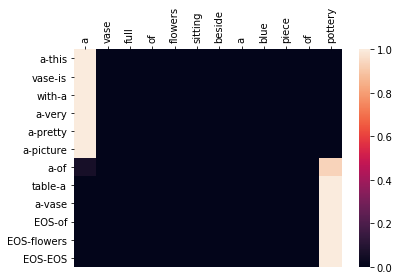

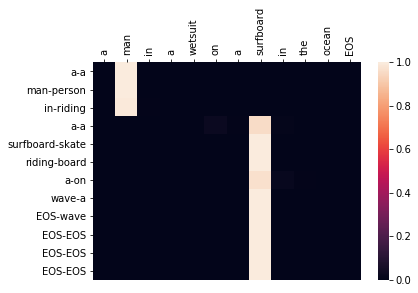

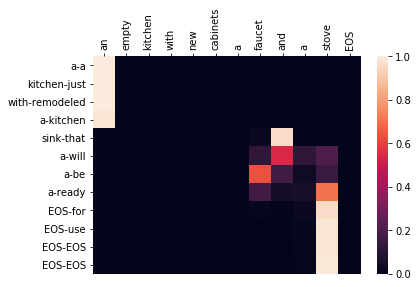

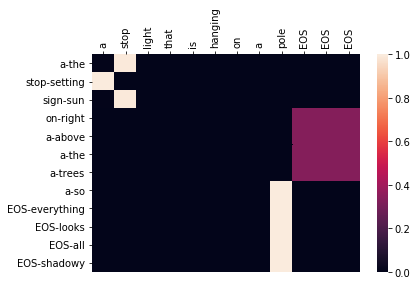

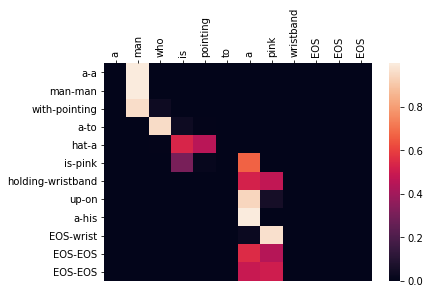



Example 1
INPUT   >> a vase full of flowers sitting beside a blue piece of pottery
PRED #1 >> a vase with a a a a table a
PRED #2 >> a vase with a a a and table a
PRED #3 >> a vase with a a a table table a
TRUE    >> this is a very pretty picture of a vase of flowers
[BLEU] 0.08

Example 2
INPUT   >> a man in a wetsuit on a surfboard in the ocean
PRED #1 >> a man in a surfboard riding a wave
PRED #2 >> a man in a wet riding a wave
PRED #3 >> a man in a surfboard a a wave
TRUE    >> a person riding a skate board on a wave
[BLEU] 0.15

Example 3
INPUT   >> an empty kitchen with new cabinets a faucet and a stove
PRED #1 >> a kitchen with a sink a a a
PRED #2 >> a kitchen with a sink and a a
PRED #3 >> a kitchen with a a a a a
TRUE    >> a just remodeled kitchen that will be ready for use
[BLEU] 0.05

Example 4
INPUT   >> a stop light that is hanging on a pole
PRED #1 >> a stop sign on a a a a
PRED #2 >> a stop sign in a a a a
PRED #3 >> a stop sign sitting a a a a
TRUE    >> the setting

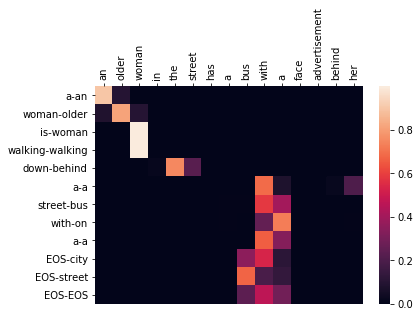

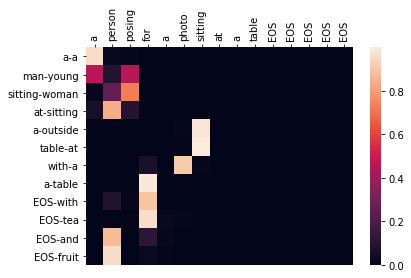

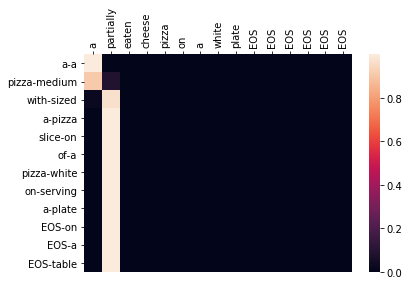

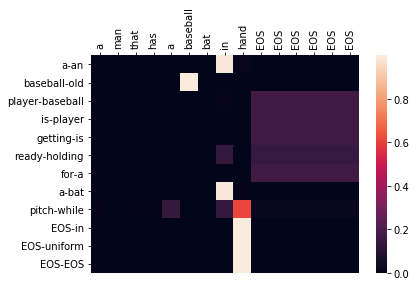

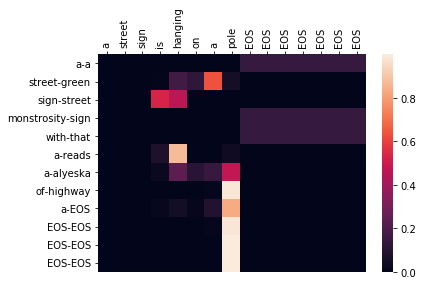



Example 1
INPUT   >> an older woman in the street has a bus with a face advertisement behind her
PRED #1 >> a woman is walking down a street with a
PRED #2 >> a woman in walking down a street with a
PRED #3 >> a woman is dressed down a street with a
TRUE    >> an older woman walking behind a bus on a city street
[BLEU] 0.06

Example 2
INPUT   >> a person posing for a photo sitting at a table
PRED #1 >> a man sitting at a table with a
PRED #2 >> a man sitting at a table with a cake
PRED #3 >> a man with at a table with a
TRUE    >> a young woman sitting outside at a table with tea and fruit
[BLEU] 0.23

Example 3
INPUT   >> a partially eaten cheese pizza on a white plate
PRED #1 >> a pizza with a slice of pizza on a
PRED #2 >> a pizza with a slice of pizza on a plate
PRED #3 >> a pizza with a slice of pizza with a
TRUE    >> a medium sized pizza on a white serving plate on a table
[BLEU] 0.14

Example 4
INPUT   >> a man that has a baseball bat in hand
PRED #1 >> a baseball player is g

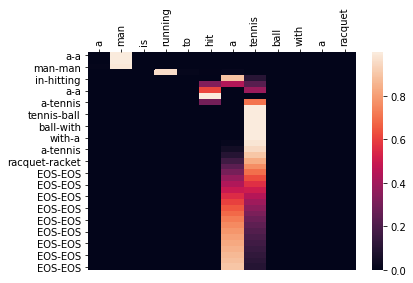

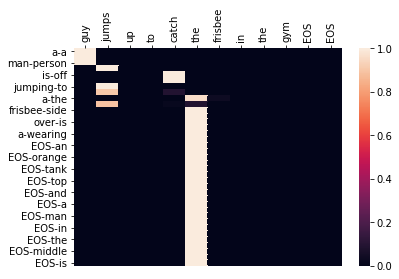

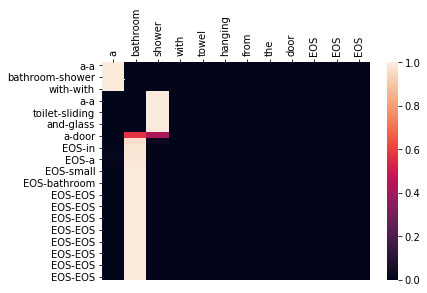

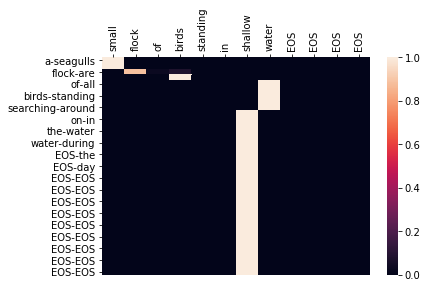

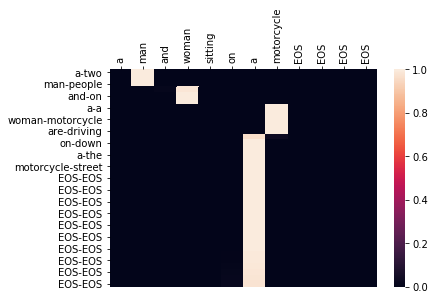



Example 1
INPUT   >> a man is running to hit a tennis ball with a racquet
PRED #1 >> a man in a a tennis ball with a racquet
PRED #2 >> a man in a a tennis ball with a
PRED #3 >> a man in a a a ball with a racquet
TRUE    >> a man hitting a tennis ball with a tennis racket
[BLEU] 0.45

Example 2
INPUT   >> guy jumps up to catch the frisbee in the gym
PRED #1 >> a man is jumping a frisbee over a
PRED #2 >> a man in jumping a frisbee over a
PRED #3 >> a man is jumping a frisbee over his
TRUE    >> a person off to the side is wearing an orange tank top and a man in the middle is jumping up in the air catching something and across from the gym is a woman and a child
[BLEU] 0.00

Example 3
INPUT   >> a bathroom shower with towel hanging from the door
PRED #1 >> a bathroom with a toilet and a
PRED #2 >> a bathroom with a toilet and a a
PRED #3 >> a bathroom with a toilet and a shower
TRUE    >> a shower with a sliding glass door in a small bathroom
[BLEU] 0.09

Example 4
INPUT   >> small f

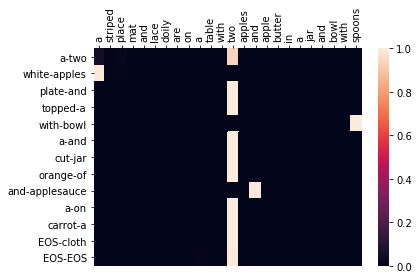

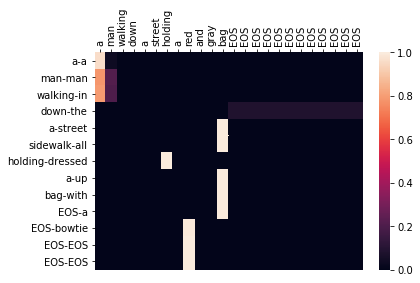

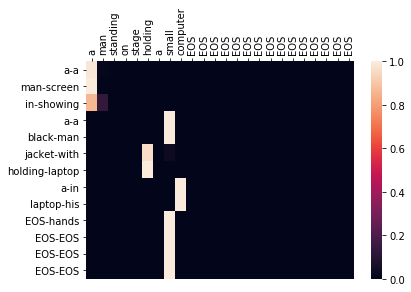

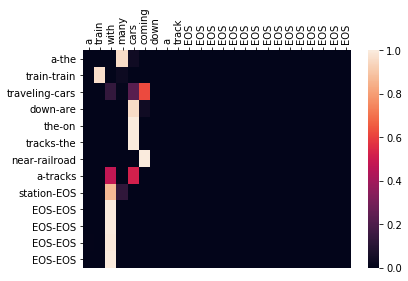

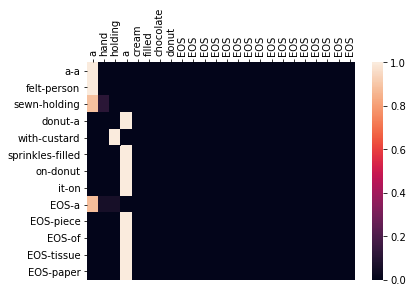



Example 1
INPUT   >> a striped place mat and lace doily are on a table with two apples and apple butter in a jar and bowl with spoons
PRED #1 >> a white plate topped with a cut orange and a carrot
PRED #2 >> a white plate topped with a banana orange and a carrot
PRED #3 >> a white plate topped with a cut apple and a carrot
TRUE    >> two apples and a bowl and jar of applesauce on a cloth
[BLEU] 0.08

Example 2
INPUT   >> a man walking down a street holding a red and gray bag
PRED #1 >> a man walking down a sidewalk holding a bag
PRED #2 >> a man walking through a sidewalk holding a bag
PRED #3 >> a man walking down a sidewalk holding a pair
TRUE    >> a man in the street all dressed up with a bowtie
[BLEU] 0.08

Example 3
INPUT   >> a man standing on stage holding a small computer
PRED #1 >> a man in a black jacket holding a laptop
PRED #2 >> a man is a black jacket holding a laptop
PRED #3 >> a man with a black jacket holding a laptop
TRUE    >> a screen showing a man with laptop in

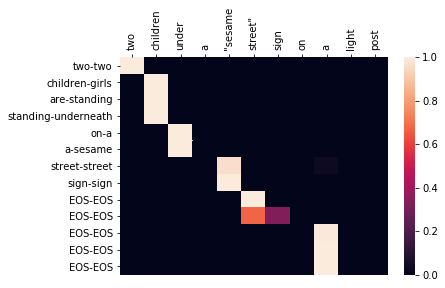

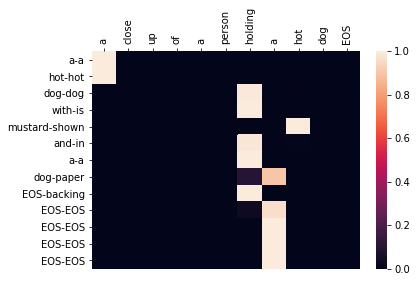

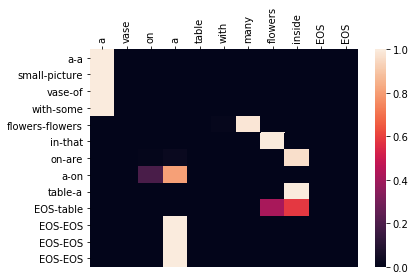

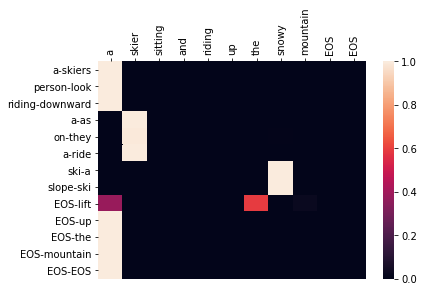

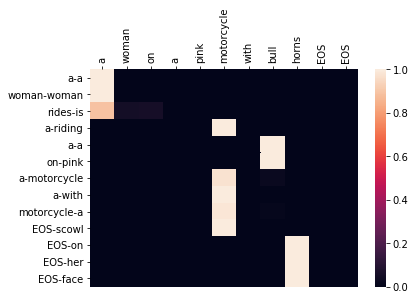



Example 1
INPUT   >> two children under a "sesame street" sign on a light post
PRED #1 >> two children are standing on a street sign
PRED #2 >> two children are standing next a street sign
PRED #3 >> two children are sitting on a street sign
TRUE    >> two girls standing underneath a sesame street sign
[BLEU] 0.14

Example 2
INPUT   >> a close up of a person holding a hot dog
PRED #1 >> a hot dog with mustard and a dog
PRED #2 >> a hot dog with mustard and a hot
PRED #3 >> a hot dog with mustard on a dog
TRUE    >> a hot dog is shown in a paper backing
[BLEU] 0.19

Example 3
INPUT   >> a vase on a table with many flowers inside
PRED #1 >> a small vase with flowers in on a table
PRED #2 >> a small vase with flowers on on a table
PRED #3 >> a small vase with a in on a table
TRUE    >> a picture of some flowers that are on a table
[BLEU] 0.18

Example 4
INPUT   >> a skier sitting and riding up the snowy mountain
PRED #1 >> a person riding a on a ski slope
PRED #2 >> a person riding a a 

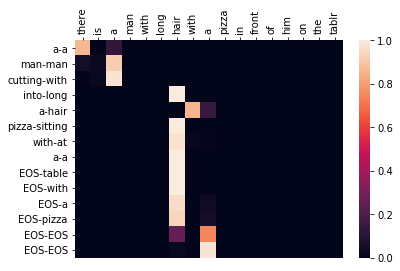

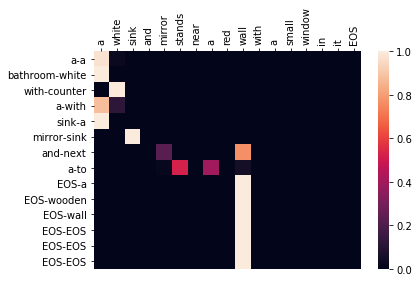

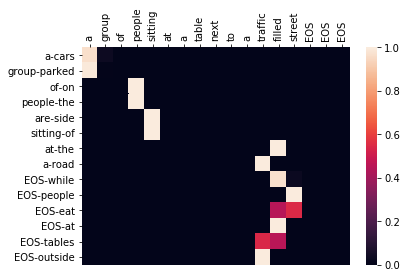

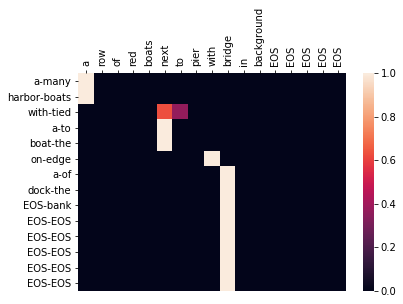

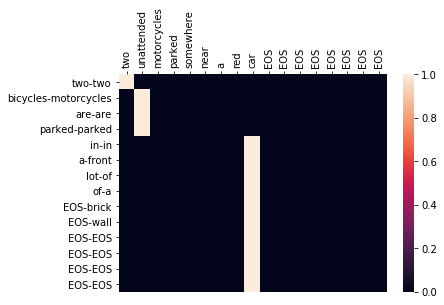



Example 1
INPUT   >> there is a man with long hair with a pizza in front of him on the tablr
PRED #1 >> a man cutting into a pizza with a
PRED #2 >> a man cutting a a pizza with a
PRED #3 >> a man is into a pizza with a
TRUE    >> a man with long hair sitting at a table with a pizza
[BLEU] 0.12

Example 2
INPUT   >> a white sink and mirror stands near a red wall with a small window in it
PRED #1 >> a bathroom with a sink mirror and a
PRED #2 >> a bathroom with a sink mirror and a window
PRED #3 >> a bathroom with a sink sink and a
TRUE    >> a white counter with a sink next to a wooden wall
[BLEU] 0.16

Example 3
INPUT   >> a group of people sitting at a table next to a traffic filled street
PRED #1 >> a group of people are sitting at a
PRED #2 >> a group of people sitting sitting at a
PRED #3 >> a group of people are sitting on a
TRUE    >> cars parked on the side of the road while people eat at tables outside
[BLEU] 0.03

Example 4
INPUT   >> a row of red boats next to pier with br

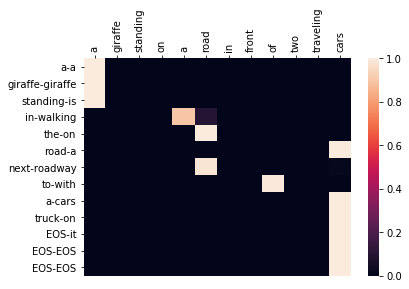

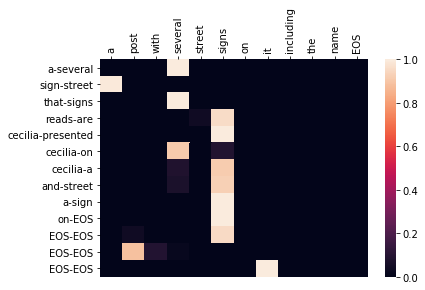

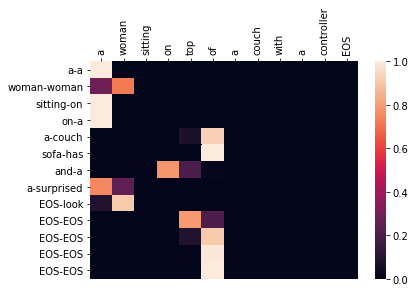

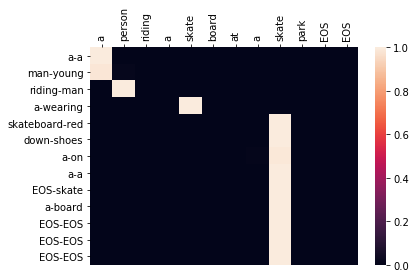

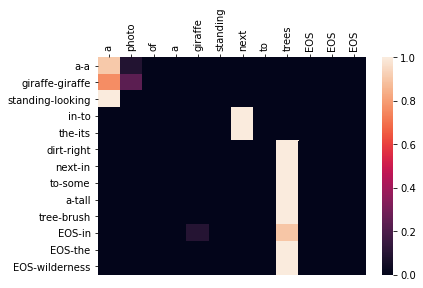



Example 1
INPUT   >> a giraffe standing on a road in front of two traveling cars
PRED #1 >> a giraffe standing in the road next to a truck
PRED #2 >> a giraffe standing in the the next to a truck
PRED #3 >> a giraffe standing in front road next to a truck
TRUE    >> a giraffe is walking on a roadway with cars on it
[BLEU] 0.08

Example 2
INPUT   >> a post with several street signs on it including the name
PRED #1 >> a sign that reads cecilia cecilia cecilia and a on
PRED #2 >> a sign that reads cecilia cecilia cecilia and a on the
PRED #3 >> a stop that reads cecilia cecilia cecilia and a on
TRUE    >> several street signs are presented on a street sign
[BLEU] 0.06

Example 3
INPUT   >> a woman sitting on top of a couch with a controller
PRED #1 >> a woman sitting on a sofa and a
PRED #2 >> a woman sitting on a sofa while a
PRED #3 >> a woman sitting on a sofa playing a
TRUE    >> a woman on a couch has a surprised look
[BLEU] 0.15

Example 4
INPUT   >> a person riding a skate board 

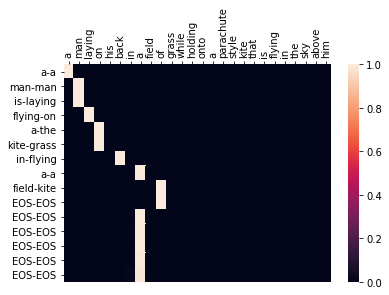

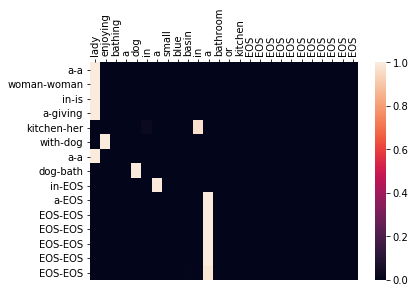

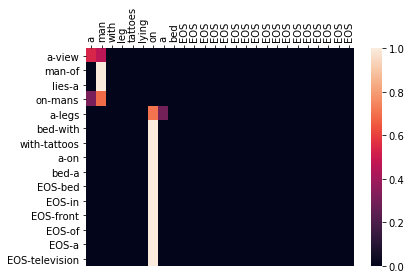

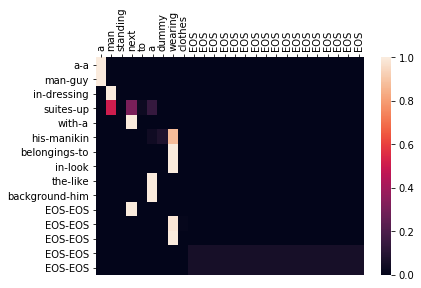

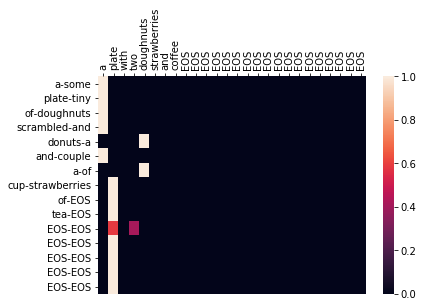



Example 1
INPUT   >> a man laying on his back in a field of grass while holding onto a parachute style kite that is flying in the sky above him
PRED #1 >> a man is flying a kite in a field
PRED #2 >> a man flying flying a kite in a field
PRED #3 >> a man is flying a butt in a field
TRUE    >> a man laying on the grass flying a kite
[BLEU] 0.22

Example 2
INPUT   >> lady enjoying bathing a dog in a small blue basin in a bathroom or kitchen
PRED #1 >> a woman in a kitchen with a dog in a
PRED #2 >> a woman in a black with a dog in a
PRED #3 >> a woman in a a with a dog in a
TRUE    >> a woman is giving her dog a bath
[BLEU] 0.10

Example 3
INPUT   >> a man with leg tattoes lying on a bed
PRED #1 >> a man lies on a bed with a bed
PRED #2 >> a man laying on a bed with a bed
PRED #3 >> a man lies on a bed in a bed
TRUE    >> view of a mans legs with tattoos on a bed in front of a television
[BLEU] 0.11

Example 4
INPUT   >> a man standing next to a dummy wearing clothes
PRED #1 >> a man i

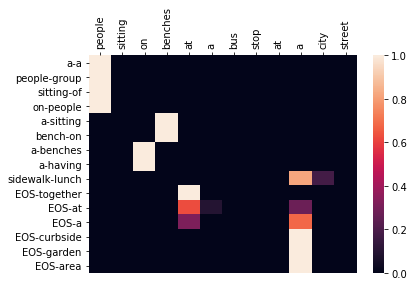

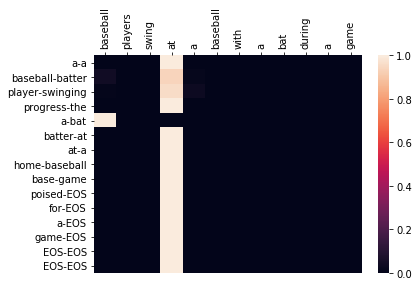

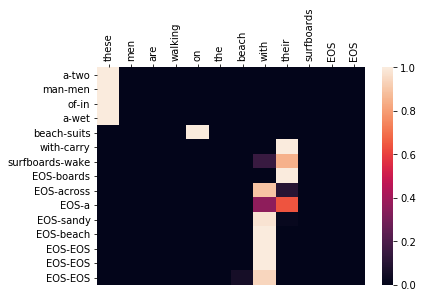

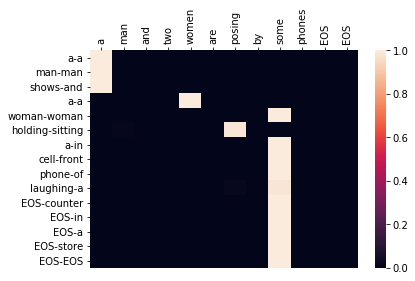

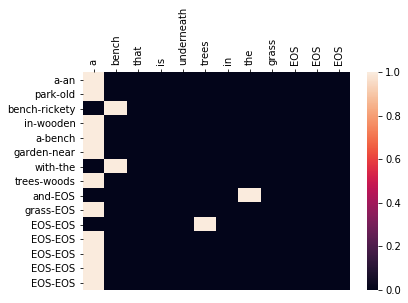



Example 1
INPUT   >> people sitting on benches at a bus stop at a city street
PRED #1 >> a people sitting on a bench a a sidewalk
PRED #2 >> a people sitting on a bench sidewalk a sidewalk
PRED #3 >> a people sitting on a bench a a
TRUE    >> a group of people sitting on benches having lunch together at a curbside garden area
[BLEU] 0.10

Example 2
INPUT   >> baseball players swing at a baseball with a bat during a game
PRED #1 >> a baseball player progress a batter at home base poised for a game
PRED #2 >> a baseball player progress a to at home base poised for a game
PRED #3 >> a baseball player progress a batter home home base poised for a game
TRUE    >> a batter swinging the bat at a baseball game
[BLEU] 0.10

Example 3
INPUT   >> these men are walking on the beach with their surfboards
PRED #1 >> a man of a beach with surfboards
PRED #2 >> a group of a beach with surfboards
PRED #3 >> a man of people beach with surfboards
TRUE    >> two men in wet suits carry wake boards across

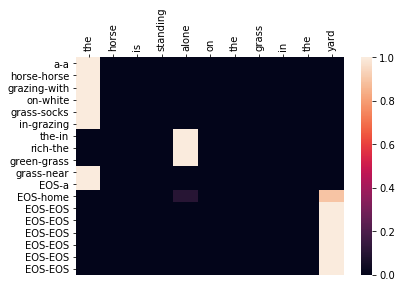

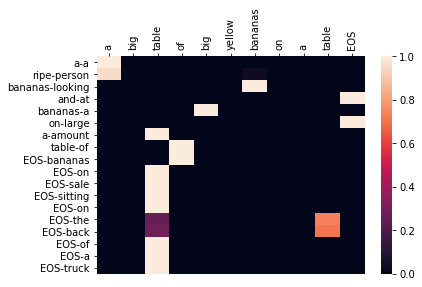

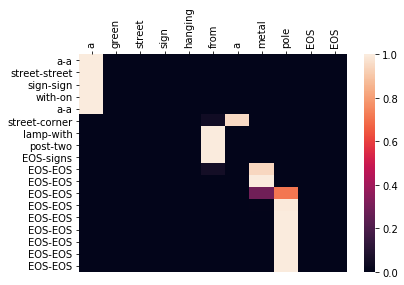

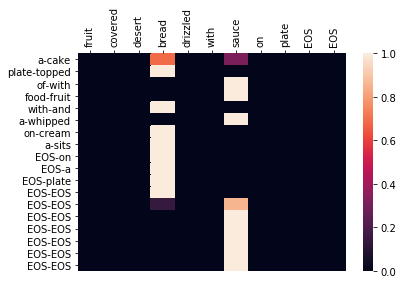

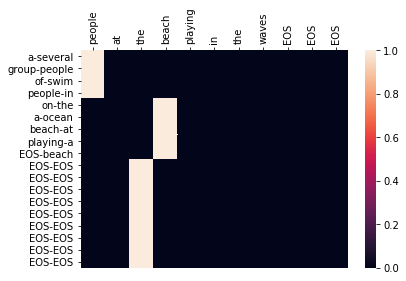



Example 1
INPUT   >> the horse is standing alone on the grass in the yard
PRED #1 >> a horse grazing on grass in the rich green grass
PRED #2 >> a brown grazing on grass in the rich green grass
PRED #3 >> a horse grazing on grass in a rich green grass
TRUE    >> a horse with white socks grazing in the grass near a home
[BLEU] 0.11

Example 2
INPUT   >> a big table of big yellow bananas on a table
PRED #1 >> a ripe bananas and bananas on a table
PRED #2 >> a ripe bananas on bananas on a table
PRED #3 >> a ripe bananas and a on a table
TRUE    >> a person looking at a large amount of bananas on sale sitting on the back of a truck
[BLEU] 0.04

Example 3
INPUT   >> a green street sign hanging from a metal pole
PRED #1 >> a street sign with a street lamp post
PRED #2 >> a street sign with a street lamp post and
PRED #3 >> a street sign that a street lamp post
TRUE    >> a street sign on a corner with two signs
[BLEU] 0.21

Example 4
INPUT   >> fruit covered desert bread drizzled with sauc

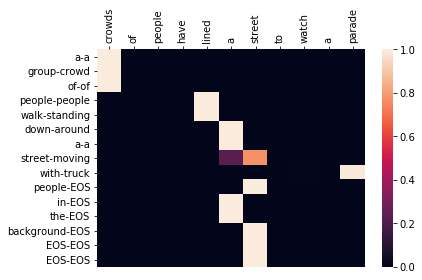

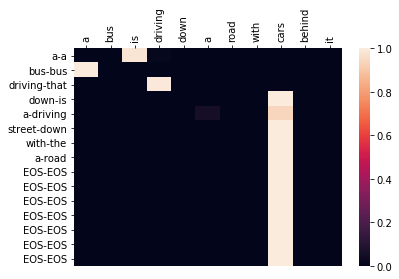

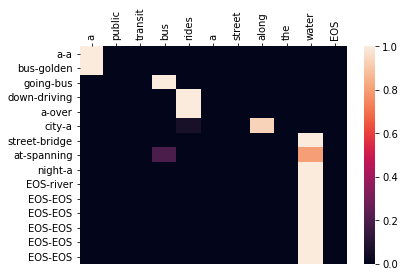

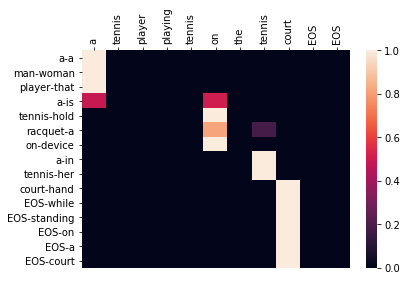

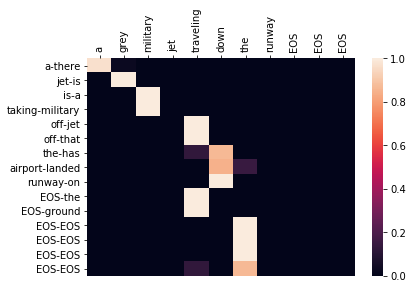



Example 1
INPUT   >> crowds of people have lined a street to watch a parade
PRED #1 >> a group of people walk down a street with people in the background
PRED #2 >> a group of people walk down a street with a in the background
PRED #3 >> a group of people walk down a street people in the background
TRUE    >> a crowd of people standing around a moving truck
[BLEU] 0.07

Example 2
INPUT   >> a bus is driving down a road with cars behind it
PRED #1 >> a bus driving down a street with a
PRED #2 >> a bus driving driving a street with a
PRED #3 >> a bus driving down a street a a
TRUE    >> a bus that is driving down the road
[BLEU] 0.16

Example 3
INPUT   >> a public transit bus rides a street along the water
PRED #1 >> a bus going down a city street at night
PRED #2 >> a bus going down a on street at night
PRED #3 >> a bus decker down a city street at night
TRUE    >> a golden bus driving over a bridge spanning a river
[BLEU] 0.06

Example 4
INPUT   >> a tennis player playing tennis on t

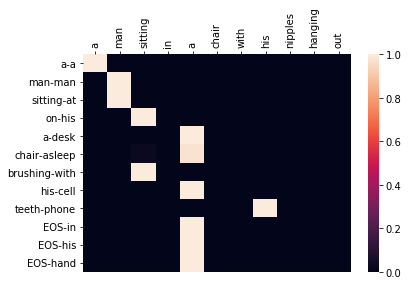

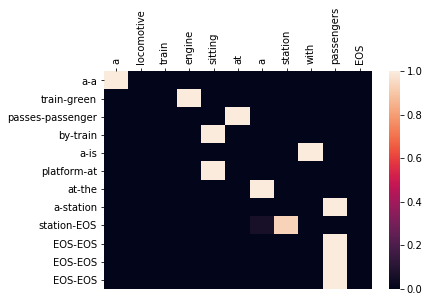

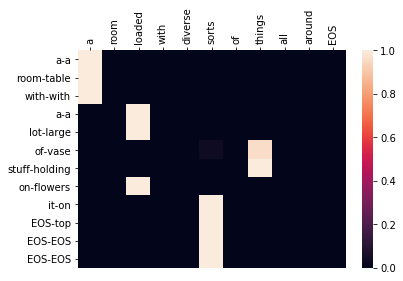

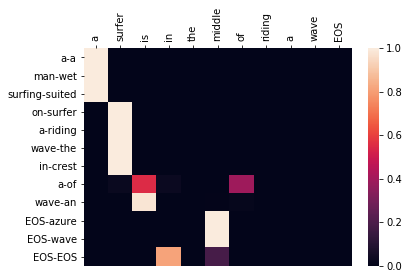

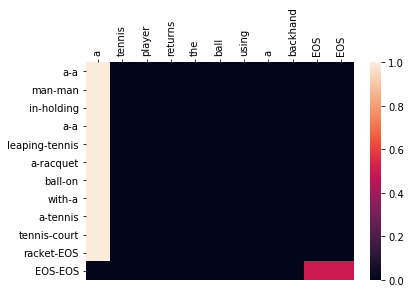



Example 1
INPUT   >> a man sitting in a chair with his nipples hanging out
PRED #1 >> a man sitting on a chair brushing his teeth
PRED #2 >> a person sitting on a chair brushing his teeth
PRED #3 >> a man sitting in a chair brushing his teeth
TRUE    >> a man at his desk asleep with cell phone in his hand
[BLEU] 0.08

Example 2
INPUT   >> a locomotive train engine sitting at a station with passengers
PRED #1 >> a train passes by a platform at a station
PRED #2 >> a train passes by a platform with a station
PRED #3 >> a train passes a a platform at a station
TRUE    >> a green passenger train is at the station
[BLEU] 0.07

Example 3
INPUT   >> a room loaded with diverse sorts of things all around
PRED #1 >> a room with a lot of stuff on it
PRED #2 >> a room with many lot of stuff on it
PRED #3 >> a room with some lot of stuff on it
TRUE    >> a table with a large vase holding flowers on top
[BLEU] 0.10

Example 4
INPUT   >> a surfer is in the middle of riding a wave
PRED #1 >> a man s

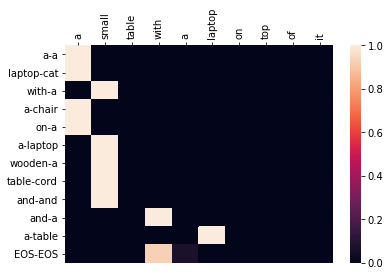

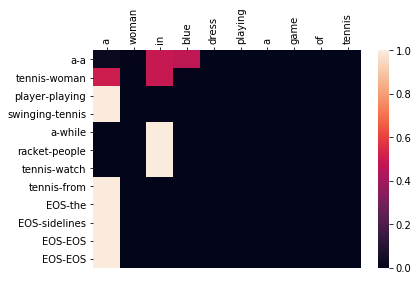

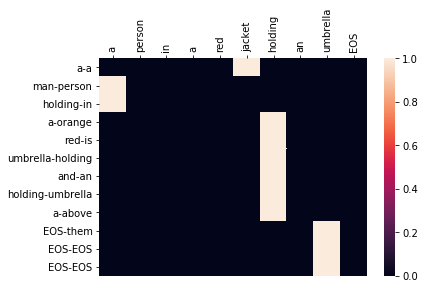

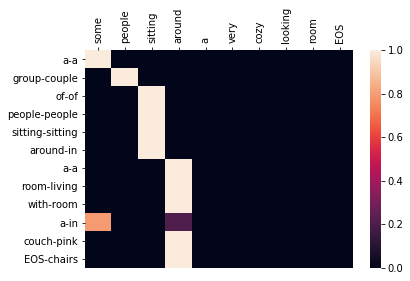

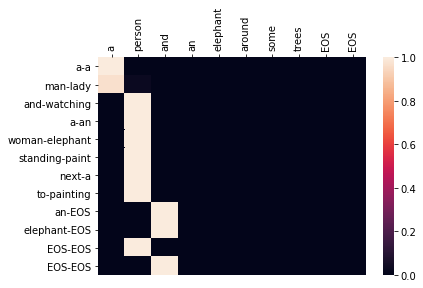



Example 1
INPUT   >> a small table with a laptop on top of it
PRED #1 >> a laptop with a on a wooden table and and a
PRED #2 >> a laptop with a cordless a wooden table and and a
PRED #3 >> a laptop with a on a wooden table and a a
TRUE    >> a cat a chair a laptop a cord and a table
[BLEU] 0.12

Example 2
INPUT   >> a woman in blue dress playing a game of tennis
PRED #1 >> a tennis player swinging a racket tennis tennis
PRED #2 >> a woman player swinging a racket tennis tennis
PRED #3 >> a girl player swinging a racket tennis tennis
TRUE    >> a woman playing tennis while people watch from the sidelines
[BLEU] 0.05

Example 3
INPUT   >> a person in a red jacket holding an umbrella
PRED #1 >> a man holding a red umbrella and holding a
PRED #2 >> a person holding a red umbrella and holding a
PRED #3 >> a man holding a red umbrella and holding a red
TRUE    >> a person in orange is holding an umbrella above them
[BLEU] 0.06

Example 4
INPUT   >> some people sitting around a very cozy lo

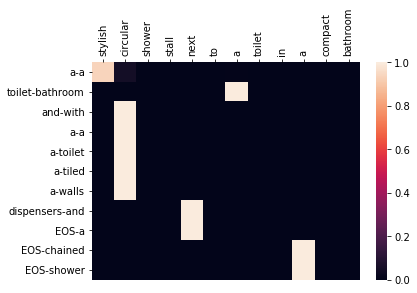

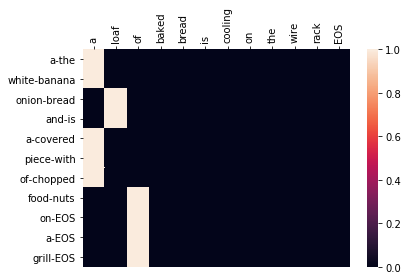

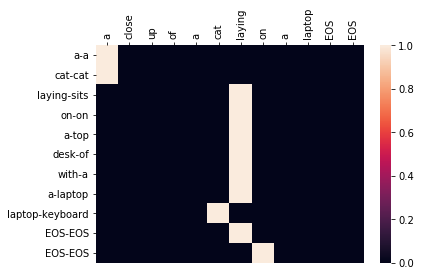

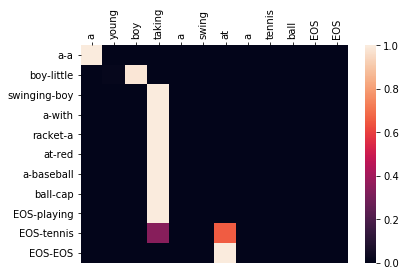

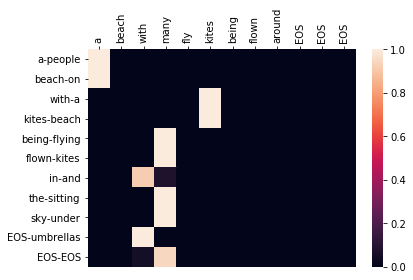



Example 1
INPUT   >> stylish circular shower stall next to a toilet in a compact bathroom
PRED #1 >> a toilet and a a a a dispensers
PRED #2 >> a toilet and a a a bathroom dispensers
PRED #3 >> a toilet is a a a a dispensers
TRUE    >> a bathroom with a toilet tiled walls and a chained shower
[BLEU] 0.11

Example 2
INPUT   >> a loaf of baked bread is cooling on the wire rack
PRED #1 >> a white onion and a piece of food on a grill
PRED #2 >> a piece onion and a piece of food on a grill
PRED #3 >> a close onion and a piece of food on a grill
TRUE    >> the banana bread is covered with chopped nuts
[BLEU] 0.00

Example 3
INPUT   >> a close up of a cat laying on a laptop
PRED #1 >> a cat laying on a desk with a laptop
PRED #2 >> a cat laying on a laptop with a laptop
PRED #3 >> a cat lays on a desk with a laptop
TRUE    >> a cat sits on top of a laptop keyboard
[BLEU] 0.14

Example 4
INPUT   >> a young boy taking a swing at a tennis ball
PRED #1 >> a boy swinging a racket at a ball
PRED 

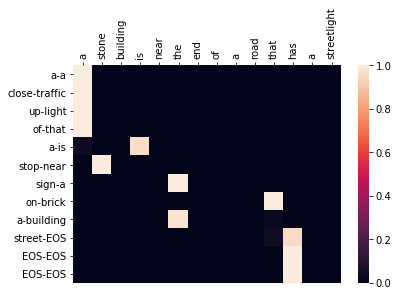

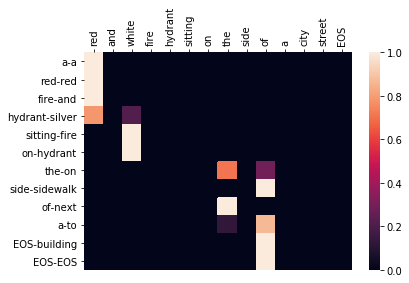

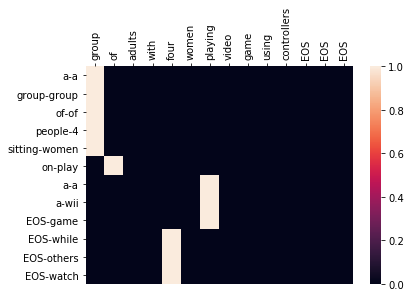

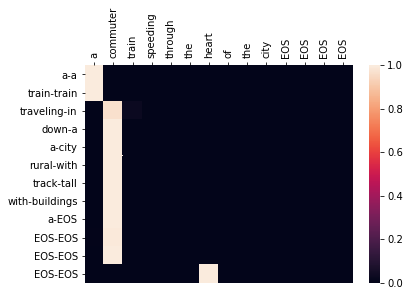

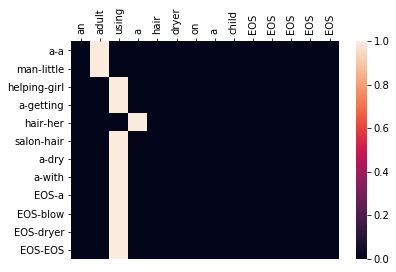



Example 1
INPUT   >> a stone building is near the end of a road that has a streetlight
PRED #1 >> a close up of a stop sign on a street
PRED #2 >> a car up of a stop sign on a street
PRED #3 >> a close up of a street sign on a street
TRUE    >> a traffic light that is near a brick building
[BLEU] 0.05

Example 2
INPUT   >> red and white fire hydrant sitting on the side of a city street
PRED #1 >> a red fire hydrant sitting on the side of a
PRED #2 >> a red fire hydrant sitting on the side of the
PRED #3 >> a red fire hydrant sitting on the side of a road
TRUE    >> a red and silver fire hydrant on sidewalk next to building
[BLEU] 0.11

Example 3
INPUT   >> group of adults with four women playing video game using controllers
PRED #1 >> a group of people sitting on a a
PRED #2 >> a group of people are on a a
PRED #3 >> a group of people sitting around a a
TRUE    >> a group of 4 women play a wii game while others watch
[BLEU] 0.13

Example 4
INPUT   >> a commuter train speeding through

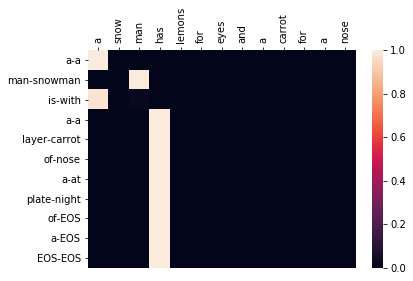

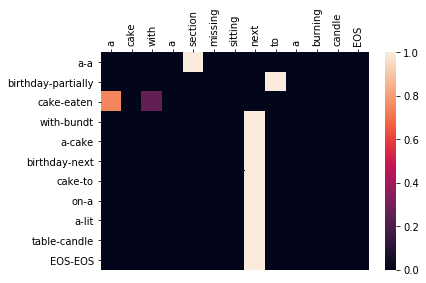

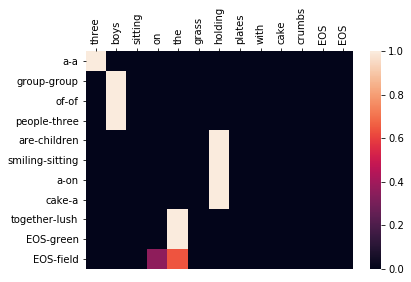

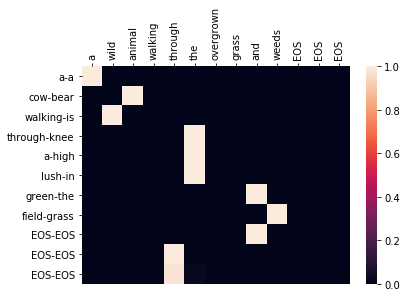

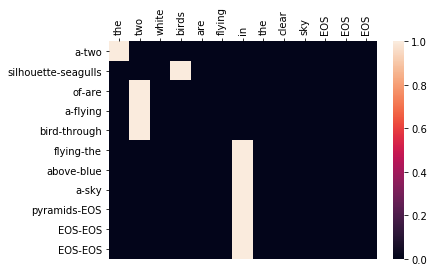



Example 1
INPUT   >> a snow man has lemons for eyes and a carrot for a nose
PRED #1 >> a man is a layer of a plate of a
PRED #2 >> a man is a layer of a a of a
PRED #3 >> a man is a the of a plate of a
TRUE    >> a snowman with a carrot nose at night
[BLEU] 0.05

Example 2
INPUT   >> a cake with a section missing sitting next to a burning candle
PRED #1 >> a birthday cake with a birthday cake on a table
PRED #2 >> a birthday cake with a a cake on a table
PRED #3 >> a birthday cake with a on cake on a table
TRUE    >> a partially eaten bundt cake next to a lit candle
[BLEU] 0.06

Example 3
INPUT   >> three boys sitting on the grass holding plates with cake crumbs
PRED #1 >> a group of people are smiling a cake together
PRED #2 >> a group of people sitting smiling a cake together
PRED #3 >> a group of young are smiling a cake together
TRUE    >> a group of three children sitting on a lush green field
[BLEU] 0.15

Example 4
INPUT   >> a wild animal walking through the overgrown grass an

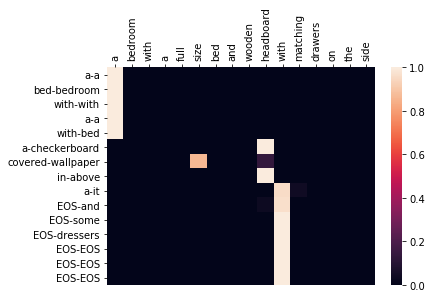

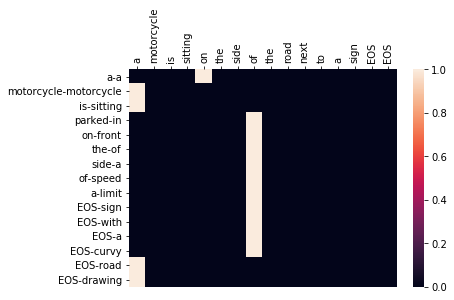

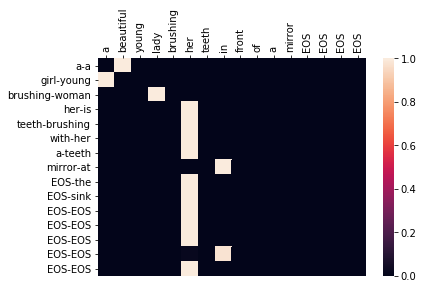

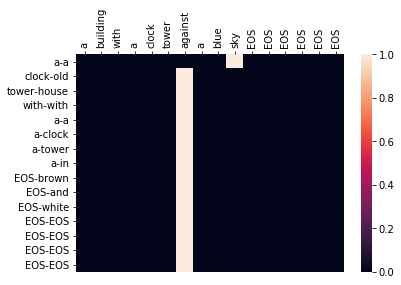

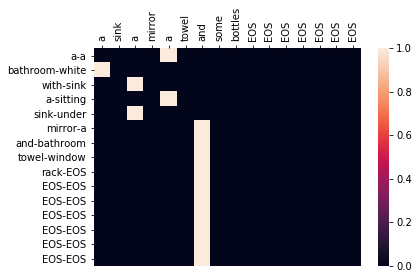



Example 1
INPUT   >> a bedroom with a full size bed and wooden headboard with matching drawers on the side
PRED #1 >> a bed with a with a covered in a
PRED #2 >> a bed with a wooden a covered in a
PRED #3 >> a bed with a with on covered in a
TRUE    >> a bedroom with a bed checkerboard wallpaper above it and some dressers
[BLEU] 0.10

Example 2
INPUT   >> a motorcycle is sitting on the side of the road next to a sign
PRED #1 >> a motorcycle is parked on the side of a
PRED #2 >> a motorcycle parked parked on the side of a
PRED #3 >> a motorcycle is parked on a side of a
TRUE    >> a motorcycle sitting in front of a speed limit sign with a curvy road drawing
[BLEU] 0.07

Example 3
INPUT   >> a beautiful young lady brushing her teeth in front of a mirror
PRED #1 >> a girl brushing her teeth with a mirror
PRED #2 >> a girl brushing her teeth with teeth mirror
PRED #3 >> a woman brushing her teeth with a mirror
TRUE    >> a young woman is brushing her teeth at the sink
[BLEU] 0.17

Exampl

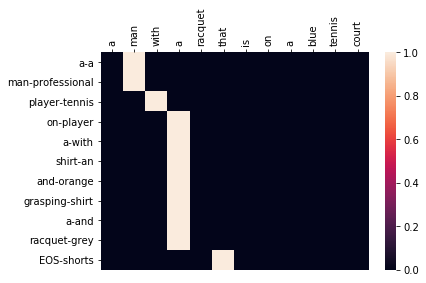

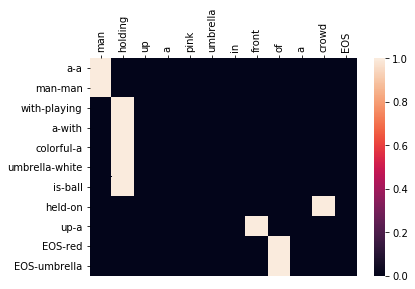

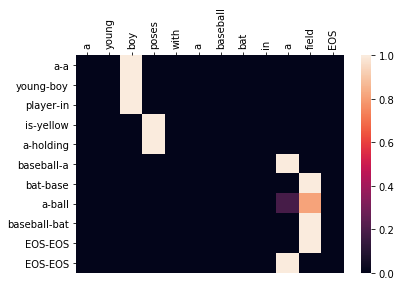

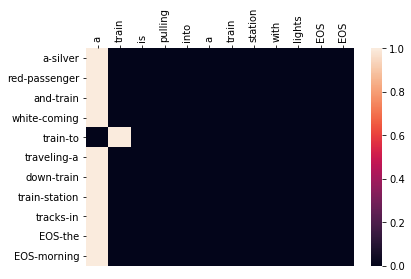

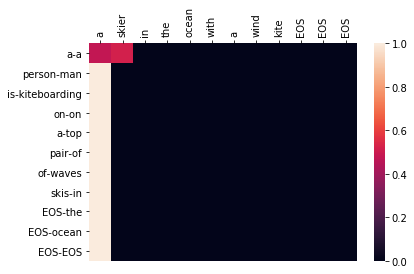



Example 1
INPUT   >> a man with a racquet that is on a blue tennis court
PRED #1 >> a man player on a shirt and grasping a racquet
PRED #2 >> a man player on a shirt and grasping a
PRED #3 >> a man player a a shirt and grasping a racquet
TRUE    >> a professional tennis player with an orange shirt and grey shorts
[BLEU] 0.09

Example 2
INPUT   >> man holding up a pink umbrella in front of a crowd
PRED #1 >> a man with a colorful umbrella is held up
PRED #2 >> a person with a colorful umbrella is held up
PRED #3 >> a man holding a colorful umbrella is held up
TRUE    >> a man playing with a white ball on a red umbrella
[BLEU] 0.11

Example 3
INPUT   >> a young boy poses with a baseball bat in a field
PRED #1 >> a young player is a baseball bat a baseball
PRED #2 >> a young player in a baseball bat a baseball
PRED #3 >> a young boy is a baseball bat a baseball
TRUE    >> a boy in yellow holding a base ball bat
[BLEU] 0.06

Example 4
INPUT   >> a train is pulling into a train station wi

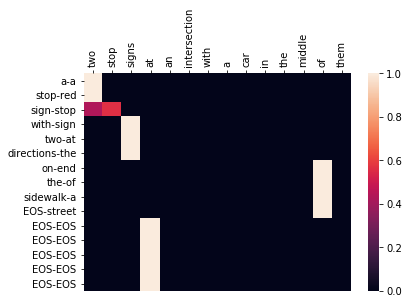

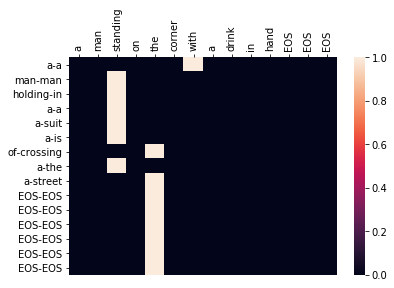

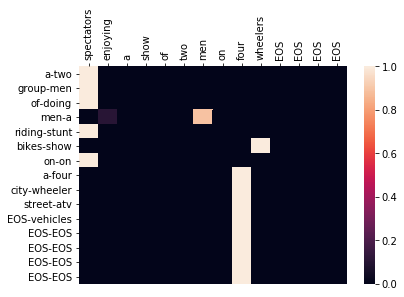

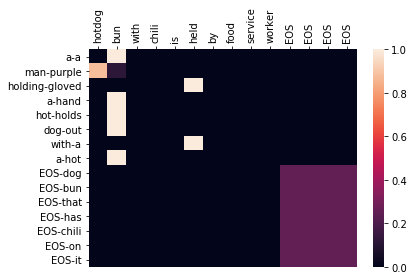

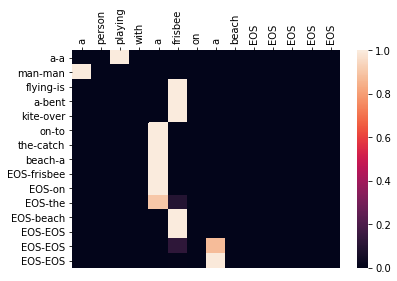



Example 1
INPUT   >> two stop signs at an intersection with a car in the middle of them
PRED #1 >> a stop sign with two directions on the sidewalk
PRED #2 >> a stop sign with two way on the sidewalk
PRED #3 >> a stop sign with two stickers on the sidewalk
TRUE    >> a red stop sign at the end of a street
[BLEU] 0.10

Example 2
INPUT   >> a man standing on the corner with a drink in hand
PRED #1 >> a man holding a a a of a a
PRED #2 >> a man holding a sandwich a of a a
PRED #3 >> a man holding a a of of a a
TRUE    >> a man in a suit is crossing the street
[BLEU] 0.11

Example 3
INPUT   >> spectators enjoying a show of two men on four wheelers
PRED #1 >> a group of men riding bikes on a city street
PRED #2 >> a group of men riding a on a city street
PRED #3 >> a group of people riding bikes on a city street
TRUE    >> two men doing a stunt show on four wheeler atv vehicles
[BLEU] 0.05

Example 4
INPUT   >> hotdog bun with chili is held by food service worker
PRED #1 >> a man holding a

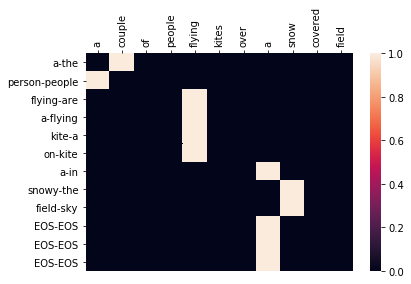

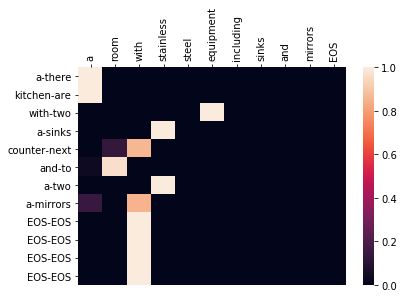

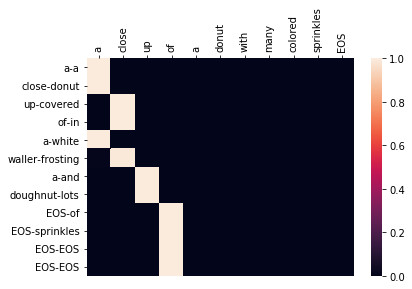

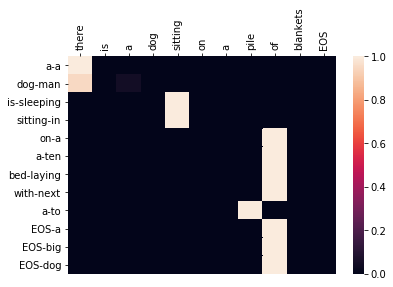

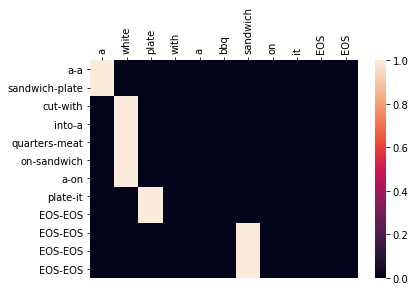



Example 1
INPUT   >> a couple of people flying kites over a snow covered field
PRED #1 >> a person flying a kite on a snowy field
PRED #2 >> a person is a kite on a snowy field
PRED #3 >> a person and a kite on a snowy field
TRUE    >> the people are flying a kite in the sky
[BLEU] 0.18

Example 2
INPUT   >> a room with stainless steel equipment including sinks and mirrors
PRED #1 >> a kitchen with a counter and a a
PRED #2 >> a modern with a counter and a a
PRED #3 >> a kitchen with a counter top a a
TRUE    >> there are two sinks next to two mirrors
[BLEU] 0.00

Example 3
INPUT   >> a close up of a donut with many colored sprinkles
PRED #1 >> a close up of a waller a doughnut
PRED #2 >> a close up of a waller a doughnut doughnut
PRED #3 >> a small up of a waller a doughnut
TRUE    >> a donut covered in white frosting and lots of sprinkles
[BLEU] 0.05

Example 4
INPUT   >> there is a dog sitting on a pile of blankets
PRED #1 >> a dog is sitting on a bed with a
PRED #2 >> a dog is si

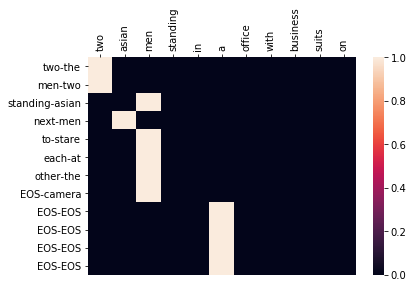

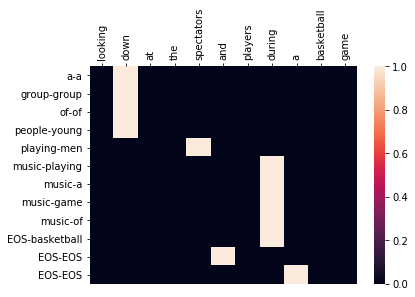

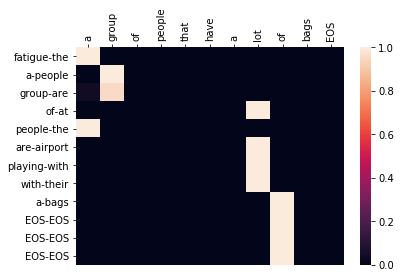

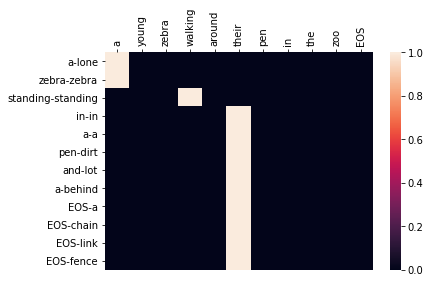

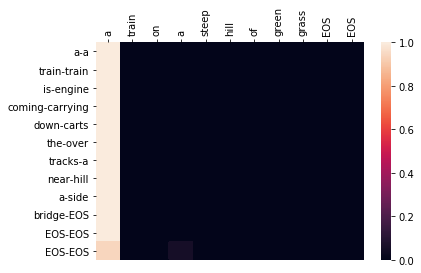



Example 1
INPUT   >> two asian men standing in a office with business suits on
PRED #1 >> two men standing next to each other
PRED #2 >> two men are next to each other
PRED #3 >> two men standing next to each other on
TRUE    >> the two asian men stare at the camera
[BLEU] 0.07

Example 2
INPUT   >> looking down at the spectators and players during a basketball game
PRED #1 >> a group of people playing music music music music
PRED #2 >> a group of people playing music music music
PRED #3 >> a singles of people playing music music music music
TRUE    >> a group of young men playing a game of basketball
[BLEU] 0.17

Example 3
INPUT   >> a group of people that have a lot of bags
PRED #1 >> fatigue a group of people are playing with a
PRED #2 >> fatigue a group of people are playing with luggage
PRED #3 >> fatigue a group of people are using with a
TRUE    >> the people are at the airport with their bags
[BLEU] 0.11

Example 4
INPUT   >> a young zebra walking around their pen in the zoo


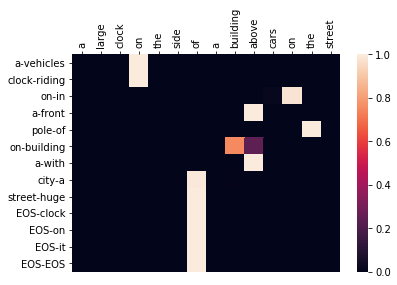

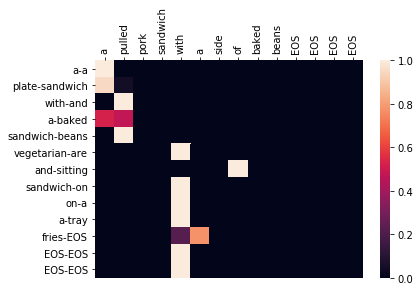

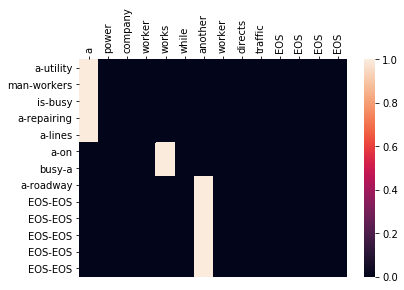

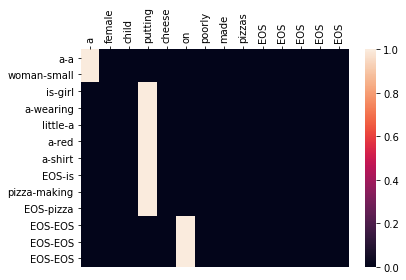

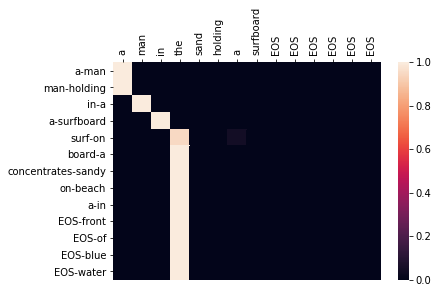



Example 1
INPUT   >> a large clock on the side of a building above cars on the street
PRED #1 >> a clock on a pole on a city street
PRED #2 >> a clock is a pole on a city street
PRED #3 >> a clock on the pole on a city street
TRUE    >> vehicles riding in front of building with a huge clock on it
[BLEU] 0.08

Example 2
INPUT   >> a pulled pork sandwich with a side of baked beans
PRED #1 >> a plate with a sandwich vegetarian and sandwich on a fries
PRED #2 >> a plate with sandwich sandwich vegetarian and sandwich on a fries
PRED #3 >> a plate with a sandwich vegetarian and sandwich on a
TRUE    >> a sandwich and baked beans are sitting on a tray
[BLEU] 0.11

Example 3
INPUT   >> a power company worker works while another worker directs traffic
PRED #1 >> a man is a a a busy a
PRED #2 >> a man is a a a busy the
PRED #3 >> a man is a truck a busy a
TRUE    >> utility workers busy repairing lines on a roadway
[BLEU] 0.07

Example 4
INPUT   >> a female child putting cheese on poorly made 

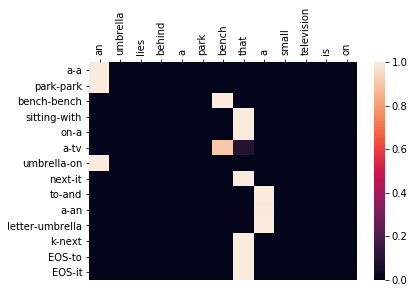

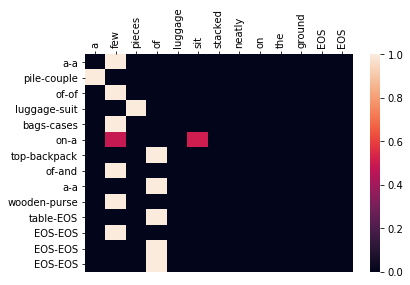

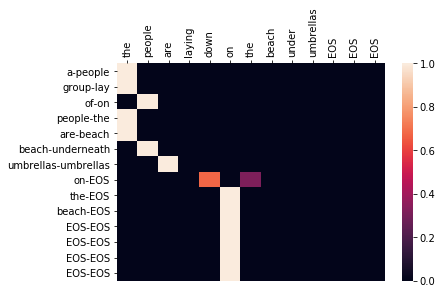

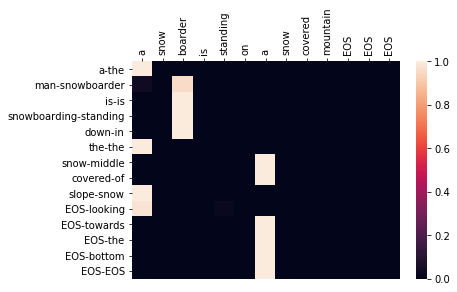

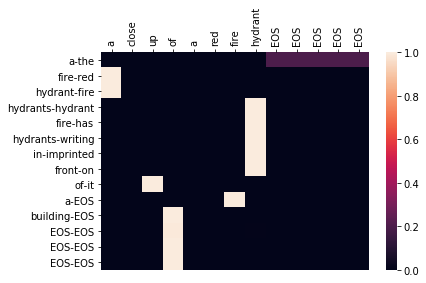



Example 1
INPUT   >> an umbrella lies behind a park bench that a small television is on
PRED #1 >> a park bench sitting on a umbrella next to a letter k
PRED #2 >> a park bench sitting in a umbrella next to a letter k
PRED #3 >> a park bench sitting on a umbrella a to a letter k
TRUE    >> a park bench with a tv on it and an umbrella next to it
[BLEU] 0.19

Example 2
INPUT   >> a few pieces of luggage sit stacked neatly on the ground
PRED #1 >> a pile of luggage bags on top of a wooden table
PRED #2 >> a pile of luggage bags of top of a wooden table
PRED #3 >> a pile of luggage on on top of a wooden table
TRUE    >> a couple of suit cases a backpack and a purse
[BLEU] 0.05

Example 3
INPUT   >> the people are laying down on the beach under umbrellas
PRED #1 >> a group of people are beach umbrellas on the beach
PRED #2 >> a group of people sitting beach umbrellas on the beach
PRED #3 >> a group of people on beach umbrellas on the beach
TRUE    >> people lay on the beach underneath umb

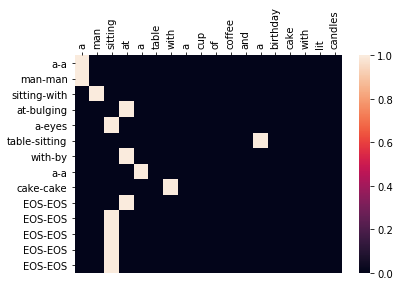

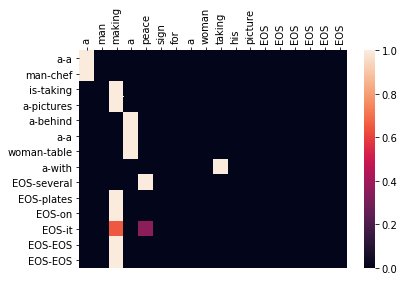

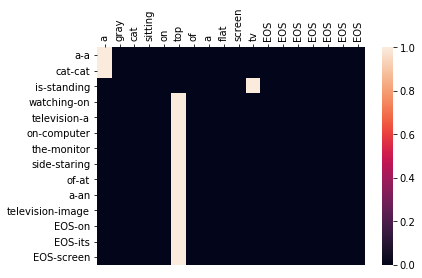

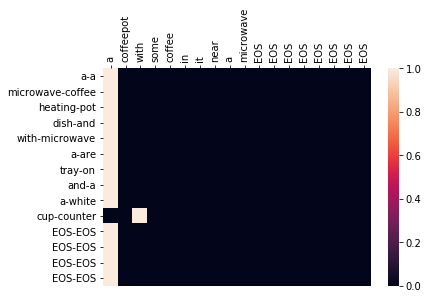

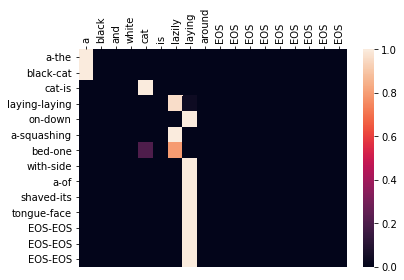



Example 1
INPUT   >> a man sitting at a table with a cup of coffee and a birthday cake with lit candles
PRED #1 >> a man sitting at a table with a cake
PRED #2 >> a man sitting at a table with cake cake
PRED #3 >> a man is at a table with a cake
TRUE    >> a man with bulging eyes sitting by a cake
[BLEU] 0.15

Example 2
INPUT   >> a man making a peace sign for a woman taking his picture
PRED #1 >> a man is a a a woman a
PRED #2 >> a man is a woman a woman a
PRED #3 >> a man is a a a a a
TRUE    >> a chef taking pictures behind a table with several plates on it
[BLEU] 0.04

Example 3
INPUT   >> a gray cat sitting on top of a flat screen tv
PRED #1 >> a cat is watching television on the side of a television
PRED #2 >> a cat is sitting television on the side of a television
PRED #3 >> a cat is watching television on the side of the television
TRUE    >> a cat standing on a computer monitor staring at an image on its screen
[BLEU] 0.07

Example 4
INPUT   >> a coffeepot with some coffee i

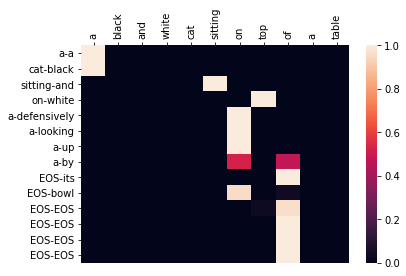

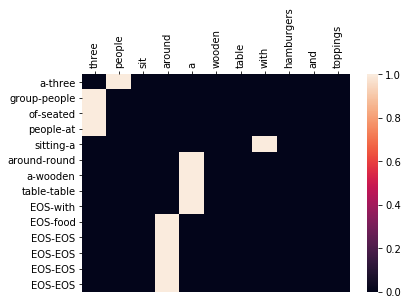

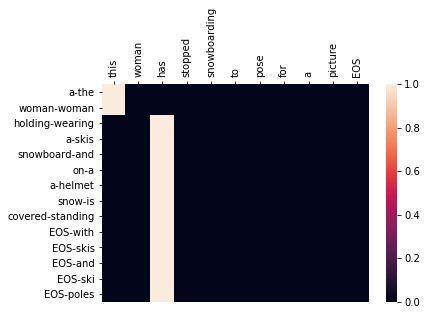

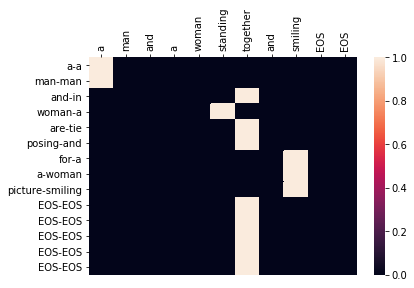

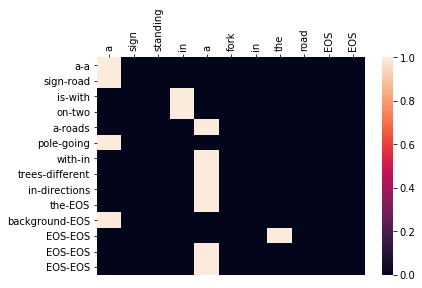



Example 1
INPUT   >> a black and white cat sitting on top of a table
PRED #1 >> a cat sitting on a a a a
PRED #2 >> a cat is on a a a a
PRED #3 >> a cat sitting on a a a
TRUE    >> a black and white defensively looking up by its bowl
[BLEU] 0.04

Example 2
INPUT   >> three people sit around a wooden table with hamburgers and toppings
PRED #1 >> a group of people sitting around a table
PRED #2 >> a group of people sitting around a table with
PRED #3 >> these group of people sitting around a table
TRUE    >> three people seated at a round wooden table with food
[BLEU] 0.06

Example 3
INPUT   >> this woman has stopped snowboarding to pose for a picture
PRED #1 >> a woman holding a snowboard on a snow covered
PRED #2 >> a woman holding a snowboard on a snow covered slope
PRED #3 >> a woman holding a snowboard on top snow covered
TRUE    >> the woman wearing skis and a helmet is standing with skis and ski poles
[BLEU] 0.03

Example 4
INPUT   >> a man and a woman standing together and smil

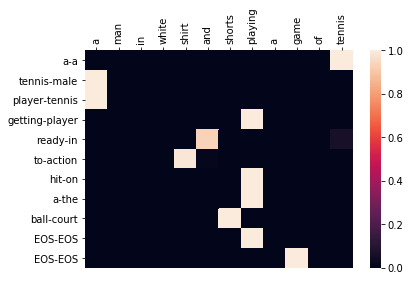

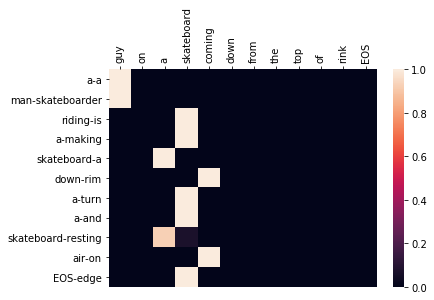

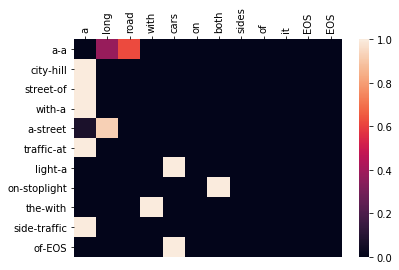

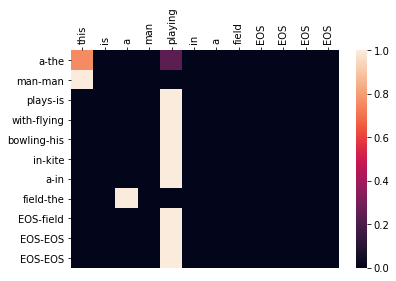

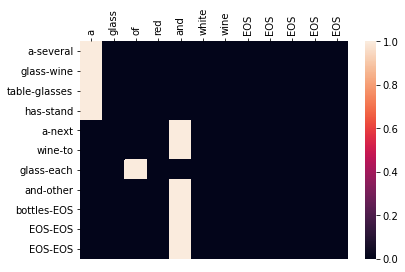



Example 1
INPUT   >> a man in white shirt and shorts playing a game of tennis
PRED #1 >> a tennis player getting ready to hit a ball
PRED #2 >> a tennis player is ready to hit a ball
PRED #3 >> a tennis player getting ready to hit the ball
TRUE    >> a male tennis player in action on the court
[BLEU] 0.11

Example 2
INPUT   >> guy on a skateboard coming down from the top of rink
PRED #1 >> a man riding a skateboard down a a skateboard air
PRED #2 >> a man riding a skateboard down a a skateboard air air
PRED #3 >> a man riding a skateboard down a air skateboard air
TRUE    >> a skateboarder is making a rim turn and resting on edge
[BLEU] 0.05

Example 3
INPUT   >> a long road with cars on both sides of it
PRED #1 >> a city street with a traffic light on the side of
PRED #2 >> a city street signpost a traffic light on the side of
PRED #3 >> a city street with a traffic light and the side of
TRUE    >> a hill of a street at a stoplight with traffic
[BLEU] 0.06

Example 4
INPUT   >> this

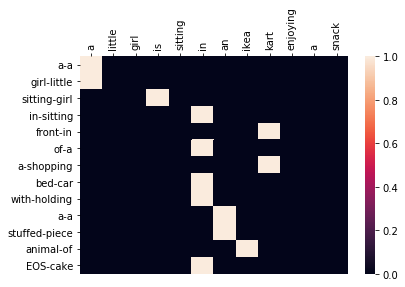

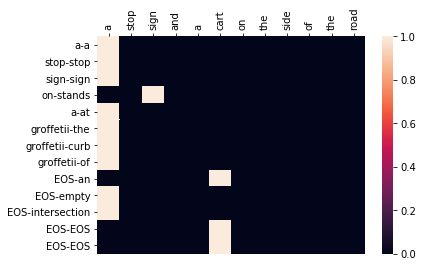

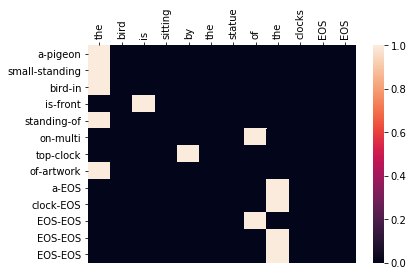

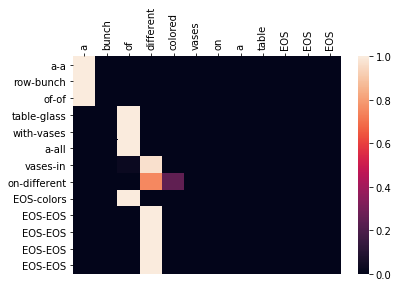

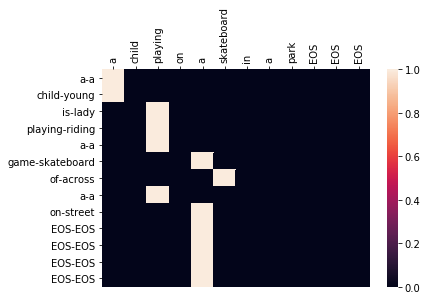



Example 1
INPUT   >> a little girl is sitting in an ikea kart enjoying a snack
PRED #1 >> a girl sitting in front of a bed with a stuffed animal
PRED #2 >> a child sitting in front of a bed with a stuffed animal
PRED #3 >> a girl sitting in a of a bed with a stuffed animal
TRUE    >> a little girl sitting in a shopping car holding a piece of cake
[BLEU] 0.14

Example 2
INPUT   >> a stop sign and a cart on the side of the road
PRED #1 >> a stop sign on a groffetii groffetii groffetii
PRED #2 >> a stop sign on the groffetii groffetii groffetii
PRED #3 >> a stop sign in a groffetii groffetii groffetii
TRUE    >> a stop sign stands at the curb of an empty intersection
[BLEU] 0.14

Example 3
INPUT   >> the bird is sitting by the statue of the clocks
PRED #1 >> a small bird is standing on top of a clock
PRED #2 >> a small bird is standing on a of a clock
PRED #3 >> a clock bird is standing on top of a clock
TRUE    >> pigeon standing in front of multi clock artwork
[BLEU] 0.06

Example 4
I

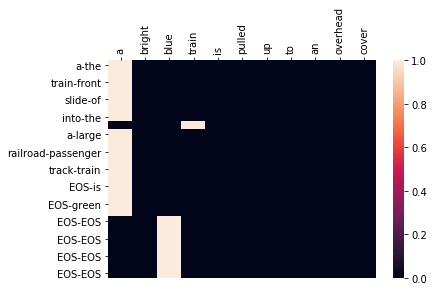

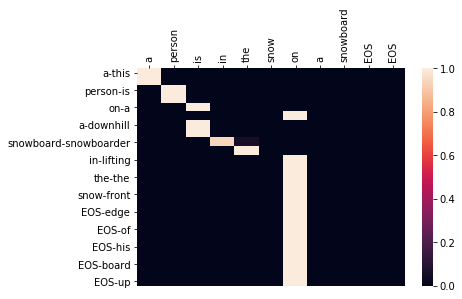

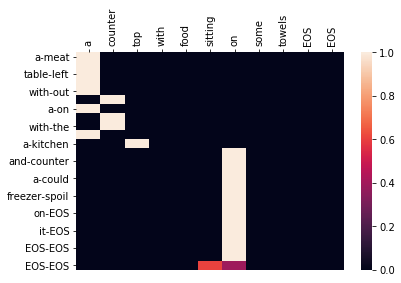

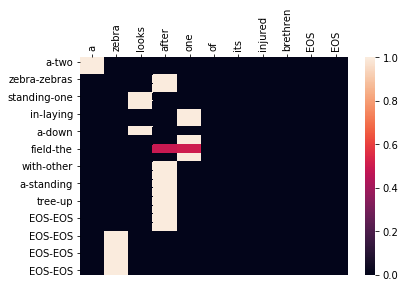

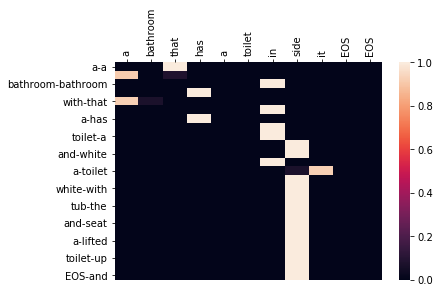



Example 1
INPUT   >> a bright blue train is pulled up to an overhead cover
PRED #1 >> a train slide into a railroad track
PRED #2 >> a train slide into the railroad track
PRED #3 >> a train slide into a railroad track with
TRUE    >> the front of the large passenger train is green
[BLEU] 0.05

Example 2
INPUT   >> a person is in the snow on a snowboard
PRED #1 >> a person on a snowboard in the snow
PRED #2 >> a person on a snowboard with the snow
PRED #3 >> a person in a snowboard in the snow
TRUE    >> this is a downhill snowboarder lifting the front edge of his board up to expose his green and yellow board to the camera
[BLEU] 0.01

Example 3
INPUT   >> a counter top with food sitting on some towels
PRED #1 >> a table with a with a and a freezer on it
PRED #2 >> a table with a plates a and a freezer on it
PRED #3 >> a table with a with a and a on it
TRUE    >> meat left out on the kitchen counter could spoil
[BLEU] 0.04

Example 4
INPUT   >> a zebra looks after one of its injured b

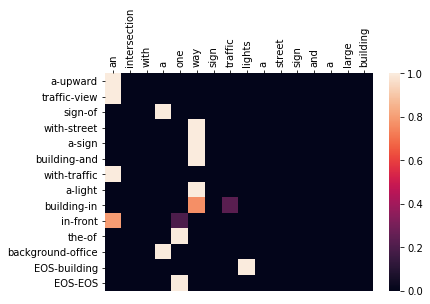

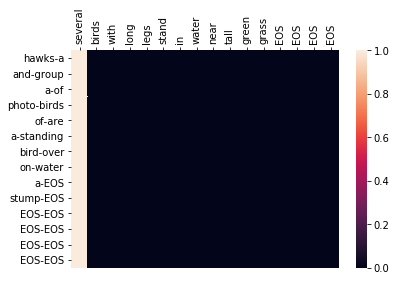

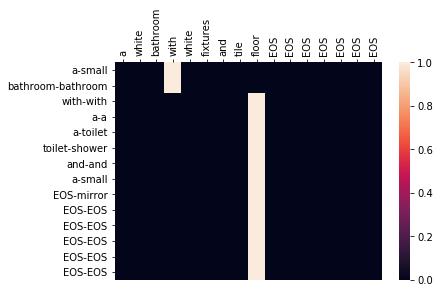

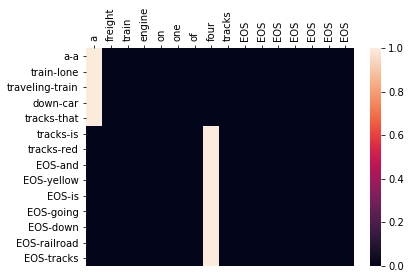

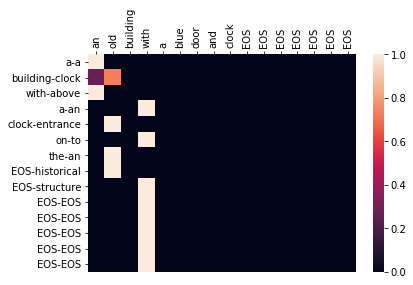



Example 1
INPUT   >> an intersection with a one way sign traffic lights a street sign and a large building
PRED #1 >> a traffic sign with a building with a building in the background
PRED #2 >> a traffic light with a building with a building in the background
PRED #3 >> a traffic sign with a building in a building in the background
TRUE    >> upward view of street sign and traffic light in front of office building
[BLEU] 0.04

Example 2
INPUT   >> several birds with long legs stand in water near tall green grass
PRED #1 >> hawks and a photo of a bird on a stump
PRED #2 >> hawks and a photo of a bird in a stump
PRED #3 >> hawks and a photo of a bird of a stump
TRUE    >> a group of birds are standing over water
[BLEU] 0.05

Example 3
INPUT   >> a white bathroom with white fixtures and tile floor
PRED #1 >> a bathroom with a a toilet and a
PRED #2 >> a bathroom with a a and and a
PRED #3 >> a bathroom with a a toilet radiator a
TRUE    >> small bathroom with a toilet shower and small m

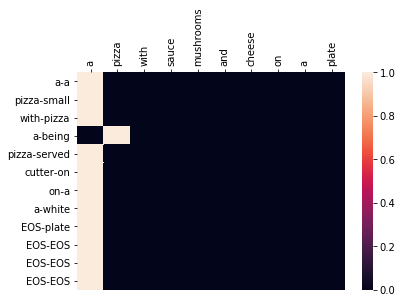

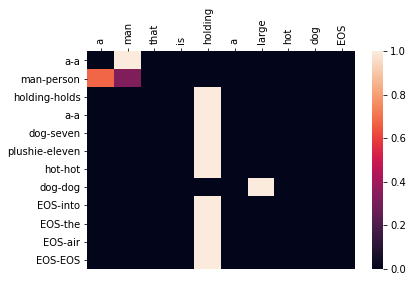

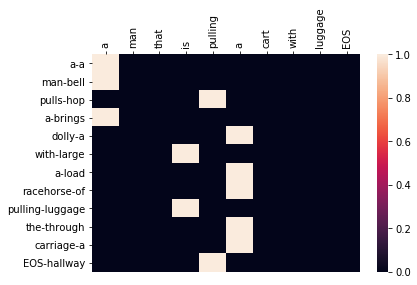

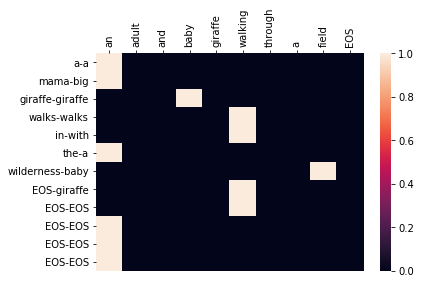

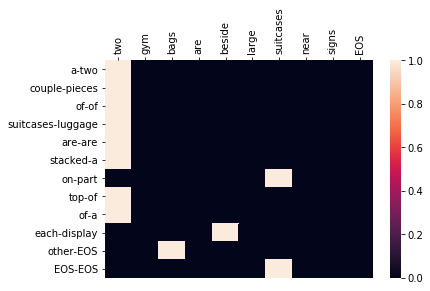



Example 1
INPUT   >> a pizza with sauce mushrooms and cheese on a plate
PRED #1 >> a pizza with a pizza cutter on a
PRED #2 >> a pizza with a pizza cutter on a a
PRED #3 >> a pizza with mozzarella pizza cutter on a
TRUE    >> a small pizza being served on a white plate
[BLEU] 0.12

Example 2
INPUT   >> a man that is holding a large hot dog
PRED #1 >> a man holding a dog plushie hot dog
PRED #2 >> a man holding a hot plushie hot dog
PRED #3 >> a man holds a dog plushie hot dog
TRUE    >> a person holds a seven eleven hot dog into the air
[BLEU] 0.09

Example 3
INPUT   >> a man that is pulling a cart with luggage
PRED #1 >> a man pulls a dolly with a racehorse pulling the carriage
PRED #2 >> a man pulls a dolly with a racehorse pulling the handle
PRED #3 >> a man pulls a dolly with a racehorse pulling the cart
TRUE    >> a bell hop brings a large load of luggage through a hallway
[BLEU] 0.05

Example 4
INPUT   >> an adult and baby giraffe walking through a field
PRED #1 >> a mama giraf

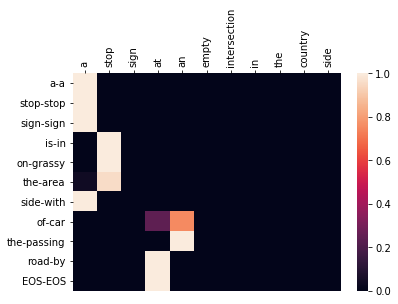

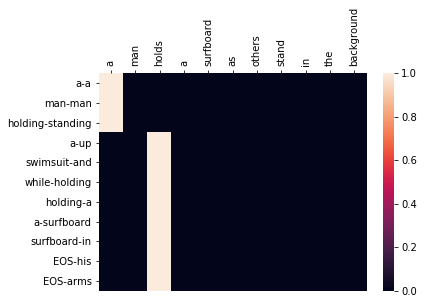

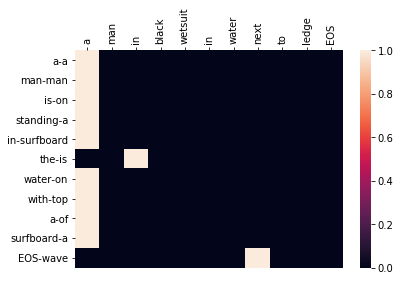

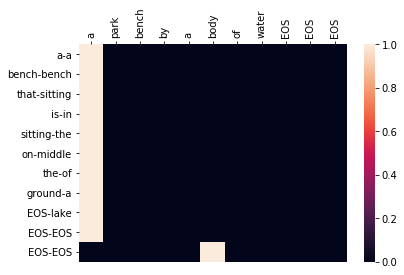

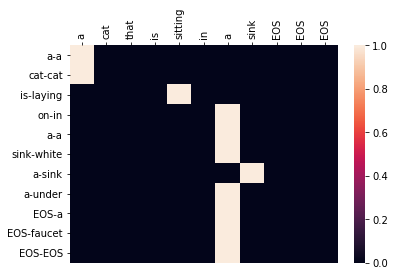



Example 1
INPUT   >> a stop sign at an empty intersection in the country side
PRED #1 >> a stop sign is on the side of the road
PRED #2 >> a stop sign is on the side of a road
PRED #3 >> a stop sign sits on the side of the road
TRUE    >> a stop sign in grassy area with car passing by
[BLEU] 0.16

Example 2
INPUT   >> a man holds a surfboard as others stand in the background
PRED #1 >> a man holding a swimsuit while holding a surfboard
PRED #2 >> a man holding a surfboard while holding a surfboard
PRED #3 >> a man holding a swimsuit of holding a surfboard
TRUE    >> a man standing up and holding a surfboard in his arms
[BLEU] 0.18

Example 3
INPUT   >> a man in black wetsuit in water next to ledge
PRED #1 >> a man is standing in the water with a surfboard
PRED #2 >> a man is surfing in the water with a surfboard
PRED #3 >> a man is standing on the water with a surfboard
TRUE    >> a man on a surfboard is on top of a wave
[BLEU] 0.11

Example 4
INPUT   >> a park bench by a body of wat

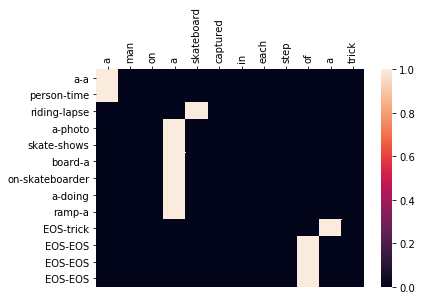

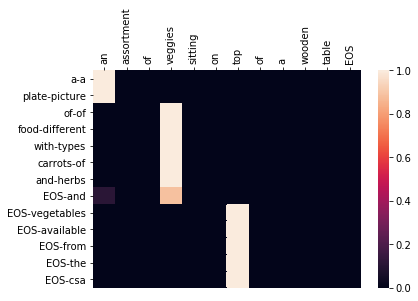

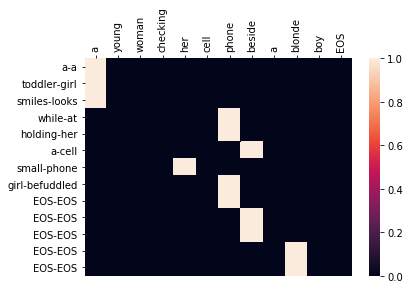

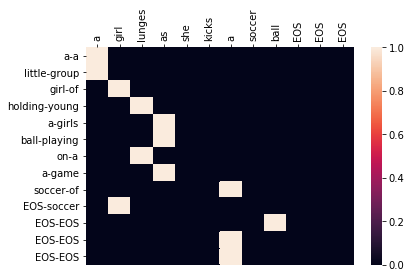

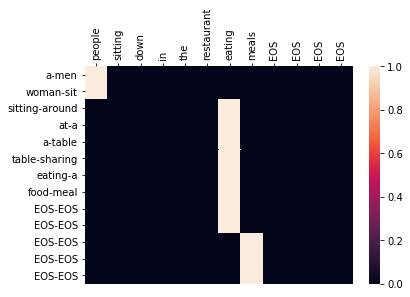



Example 1
INPUT   >> a man on a skateboard captured in each step of a trick
PRED #1 >> a person riding a skate board on a ramp
PRED #2 >> a person riding a skate board a a ramp
PRED #3 >> a person riding a skate board at a ramp
TRUE    >> a time lapse photo shows a skateboarder doing a trick
[BLEU] 0.06

Example 2
INPUT   >> an assortment of veggies sitting on top of a wooden table
PRED #1 >> a plate of food with carrots and
PRED #2 >> a plate of food with a and
PRED #3 >> a plate of food with carrots and green
TRUE    >> a picture of different types of herbs and vegetables available from the csa
[BLEU] 0.04

Example 3
INPUT   >> a young woman checking her cell phone beside a blonde boy
PRED #1 >> a toddler smiles while holding a small girl
PRED #2 >> a toddler smiles while holding a a girl
PRED #3 >> a small smiles while holding a small girl
TRUE    >> a girl looks at her cell phone befuddled
[BLEU] 0.07

Example 4
INPUT   >> a girl lunges as she kicks a soccer ball
PRED #1 >> a lit

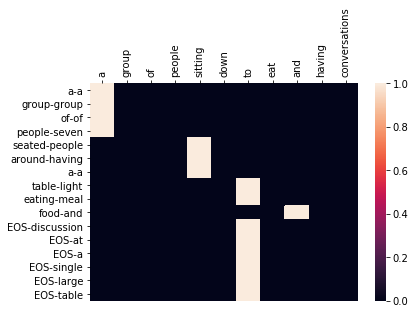

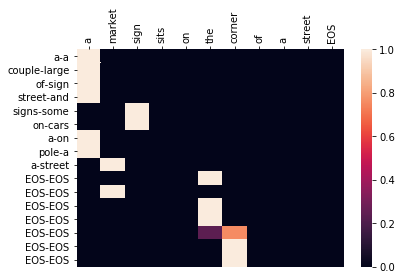

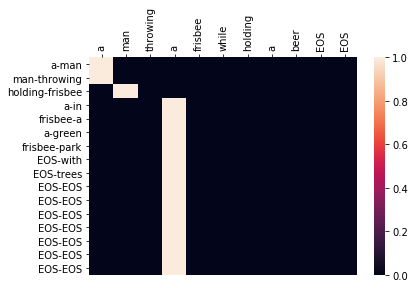

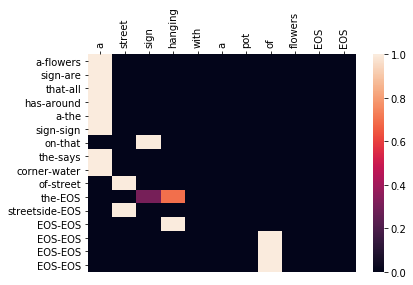

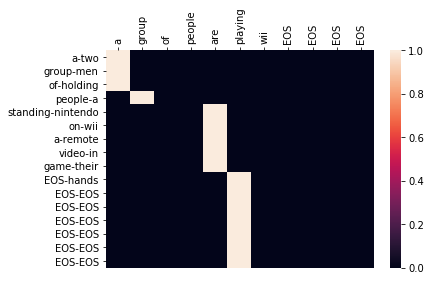



Example 1
INPUT   >> a group of people sitting down to eat and having conversations
PRED #1 >> a group of people seated around a table eating food
PRED #2 >> a group of people sitting around a table eating food
PRED #3 >> a group of people seated at a table eating food
TRUE    >> a group of seven people having a light meal and discussion at a single large table
[BLEU] 0.10

Example 2
INPUT   >> a market sign sits on the corner of a street
PRED #1 >> a couple of street signs on a pole a
PRED #2 >> a couple of street signs that a pole a
PRED #3 >> a couple of street signs on a pole a sign
TRUE    >> a large sign and some cars on a street
[BLEU] 0.11

Example 3
INPUT   >> a man throwing a frisbee while holding a beer
PRED #1 >> a man holding a frisbee a frisbee
PRED #2 >> a man holding a frisbee in frisbee
PRED #3 >> a man serving a frisbee a frisbee
TRUE    >> man throwing frisbee in a green park with trees
[BLEU] 0.06

Example 4
INPUT   >> a street sign hanging with a pot of flowers
P

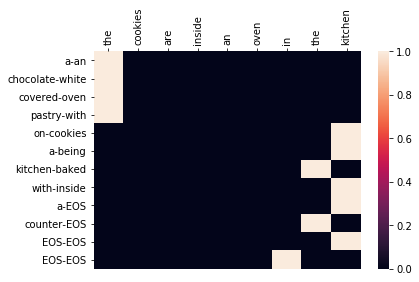

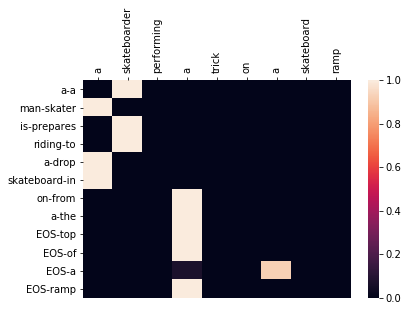

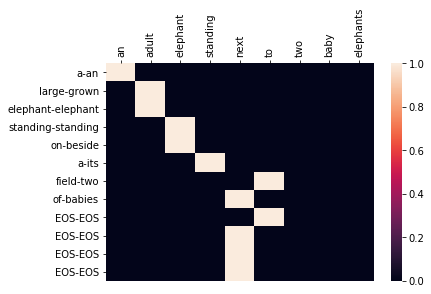

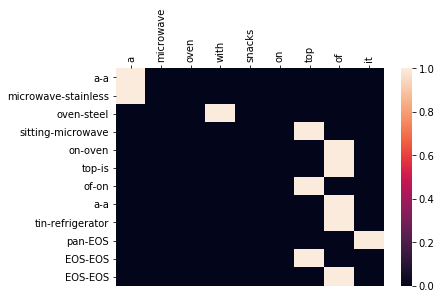

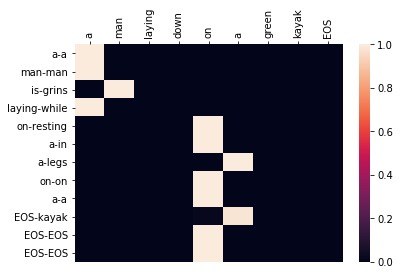



Example 1
INPUT   >> the cookies are inside an oven in the kitchen
PRED #1 >> a chocolate covered pastry on a kitchen with a counter
PRED #2 >> a big covered pastry on a kitchen with a counter
PRED #3 >> a microwave covered pastry on a kitchen with a counter
TRUE    >> an white oven with cookies being baked inside
[BLEU] 0.04

Example 2
INPUT   >> a skateboarder performing a trick on a skateboard ramp
PRED #1 >> a man is riding a skateboard on a
PRED #2 >> a man performs riding a skateboard on a
PRED #3 >> a man is doing a skateboard on a
TRUE    >> a skater prepares to drop in from the top of a ramp
[BLEU] 0.04

Example 3
INPUT   >> an adult elephant standing next to two baby elephants
PRED #1 >> a large elephant standing on a field of
PRED #2 >> a large elephant standing next a field of
PRED #3 >> a large elephant standing on a field by
TRUE    >> an grown elephant standing beside its two babies
[BLEU] 0.11

Example 4
INPUT   >> a microwave oven with snacks on top of it
PRED #1 >> 

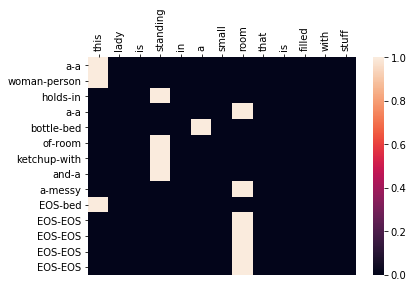

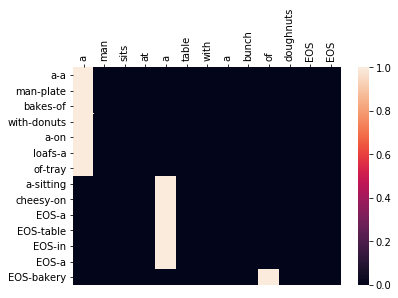

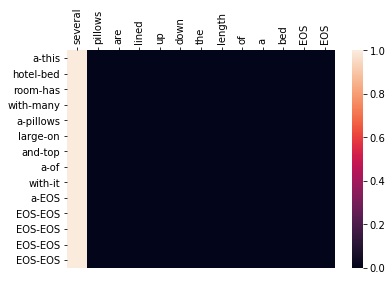

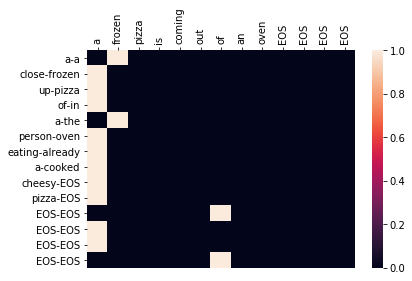

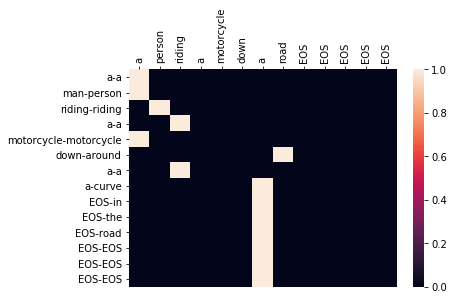



Example 1
INPUT   >> this lady is standing in a small room that is filled with stuff
PRED #1 >> a woman holds a bottle of ketchup and a
PRED #2 >> a woman holds a bottle of a and a
PRED #3 >> a woman holds up bottle of ketchup and a
TRUE    >> a person in a bed room with a messy bed
[BLEU] 0.06

Example 2
INPUT   >> a man sits at a table with a bunch of doughnuts
PRED #1 >> a man bakes with a loafs of a cheesy
PRED #2 >> a man bakes with a loafs of a
PRED #3 >> a close bakes with a loafs of a cheesy
TRUE    >> a plate of donuts on a tray sitting on a table in a bakery
[BLEU] 0.04

Example 3
INPUT   >> several pillows are lined up down the length of a bed
PRED #1 >> a hotel room with a large and a with a
PRED #2 >> a hotel room with a large and a a a
PRED #3 >> a large room with a large and a with a
TRUE    >> this bed has many pillows on top of it
[BLEU] 0.00

Example 4
INPUT   >> a frozen pizza is coming out of an oven
PRED #1 >> a close up of a person eating a cheesy pizza
PRED #2 

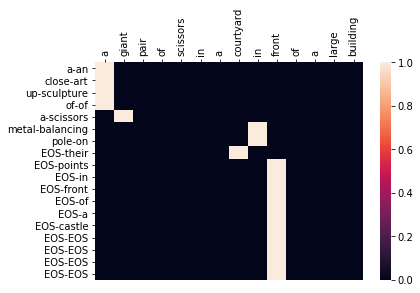

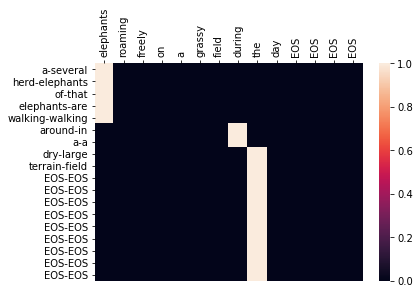

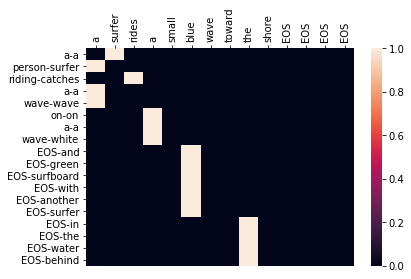

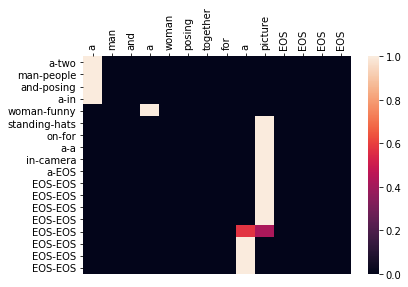

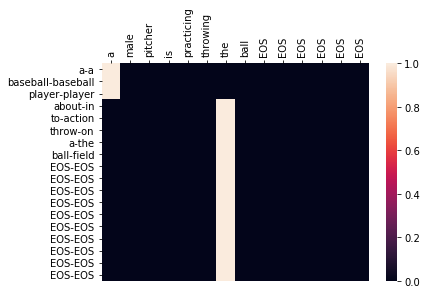



Example 1
INPUT   >> a giant pair of scissors in a courtyard in front of a large building
PRED #1 >> a close up of a metal pole
PRED #2 >> a close up of a metal pole with
PRED #3 >> a close up of a metal pole in
TRUE    >> an art sculpture of scissors balancing on their points in front of a castle
[BLEU] 0.05

Example 2
INPUT   >> elephants roaming freely on a grassy field during the day
PRED #1 >> a herd of elephants walking around a dry terrain
PRED #2 >> a herd of elephants walking around a grassy terrain
PRED #3 >> a herd of elephants walking across a dry terrain
TRUE    >> several elephants that are walking in a large field
[BLEU] 0.06

Example 3
INPUT   >> a surfer rides a small blue wave toward the shore
PRED #1 >> a person riding a wave on a wave
PRED #2 >> a man riding a wave on a wave
PRED #3 >> a person using a wave on a wave
TRUE    >> a surfer catches a wave on a white and green surfboard with another surfer in the water behind
[BLEU] 0.10

Example 4
INPUT   >> a man and

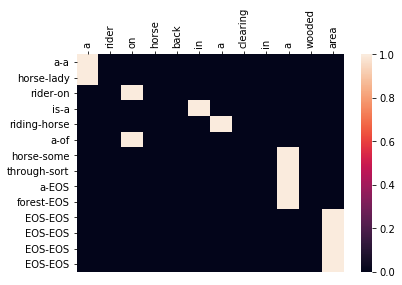

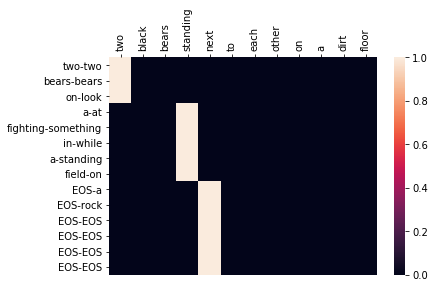

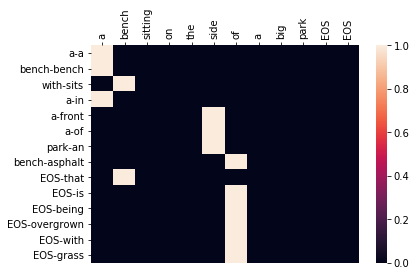

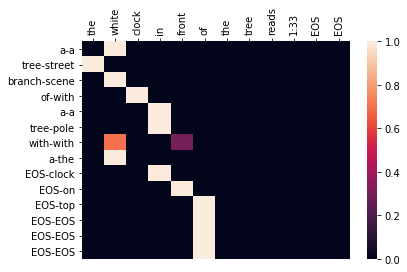

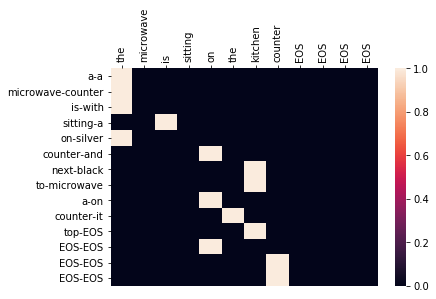



Example 1
INPUT   >> a rider on horse back in a clearing in a wooded area
PRED #1 >> a horse rider is riding a horse through a forest
PRED #2 >> a horse rider is riding a horse in a forest
PRED #3 >> a horse rider is riding a horse through the forest
TRUE    >> a lady on a horse of some sort
[BLEU] 0.09

Example 2
INPUT   >> two black bears standing next to each other on a dirt floor
PRED #1 >> two bears on a fighting in a field
PRED #2 >> two bears on a patch in a field
PRED #3 >> two bears on a fighting in the field
TRUE    >> two bears look at something while standing on a rock
[BLEU] 0.12

Example 3
INPUT   >> a bench sitting on the side of a big park
PRED #1 >> a bench with a a a park bench
PRED #2 >> a bench with a a a a bench
PRED #3 >> a bench with a a bench park bench
TRUE    >> a bench sits in front of an asphalt that is being overgrown with grass
[BLEU] 0.06

Example 4
INPUT   >> the white clock in front of the tree reads 1:33
PRED #1 >> a tree branch of a tree with a
PRED

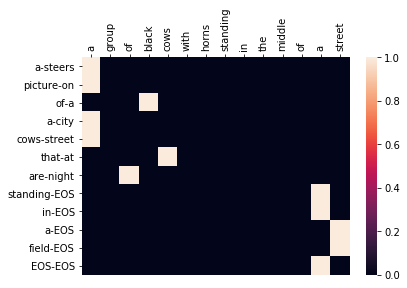

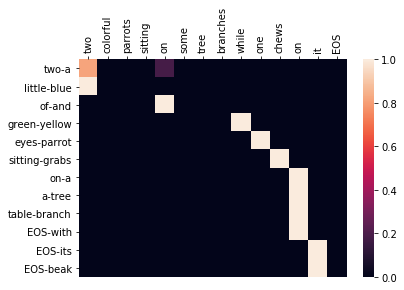

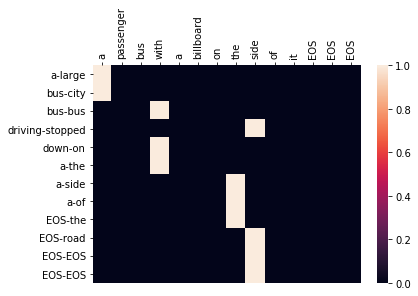

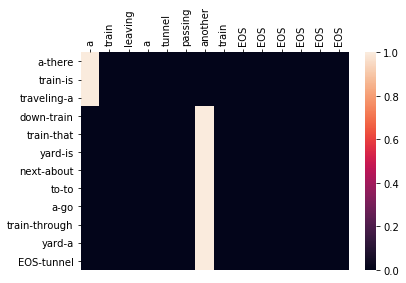

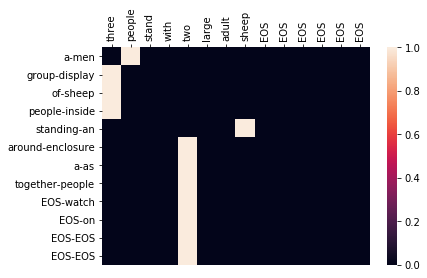



Example 1
INPUT   >> a group of black cows with horns standing in the middle of a street
PRED #1 >> a picture of a cows that are standing in a field
PRED #2 >> a picture of a cows in are standing in a field
PRED #3 >> a picture of a cows that are standing in the field
TRUE    >> steers on a city street at night
[BLEU] 0.04

Example 2
INPUT   >> two colorful parrots sitting on some tree branches while one chews on it
PRED #1 >> two little of green eyes sitting on a table
PRED #2 >> two little of a eyes sitting on a table
PRED #3 >> two little are green eyes sitting on a table
TRUE    >> a blue and yellow parrot grabs a tree branch with its beak
[BLEU] 0.03

Example 3
INPUT   >> a passenger bus with a billboard on the side of it
PRED #1 >> a bus bus driving down a a a
PRED #2 >> a bus bus driving down a street a
PRED #3 >> a bus bus driving down a a a a
TRUE    >> large city bus stopped on the side of the road
[BLEU] 0.04

Example 4
INPUT   >> a train leaving a tunnel passing another t

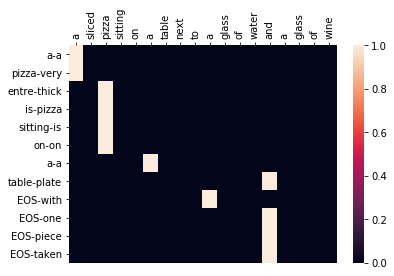

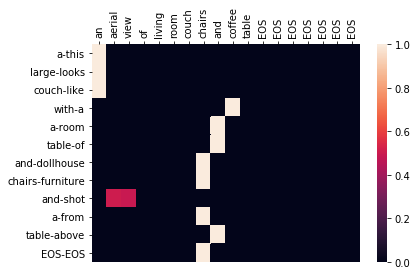

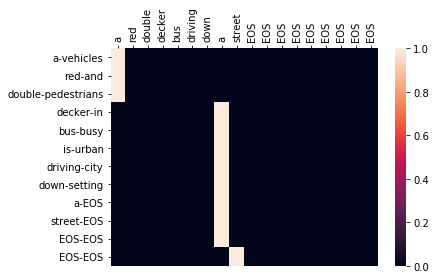

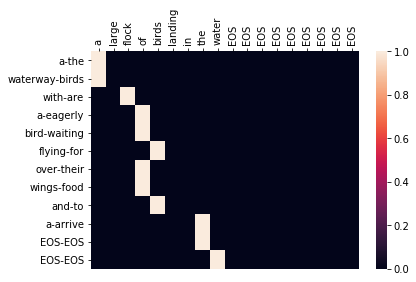

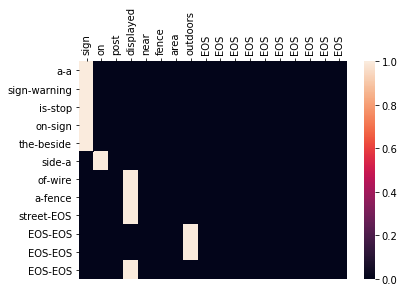



Example 1
INPUT   >> a sliced pizza sitting on a table next to a glass of water and a glass of wine
PRED #1 >> a pizza entre is sitting on a table
PRED #2 >> a pizza entre is sitting on top table
PRED #3 >> a pizza entre is laid on a table
TRUE    >> a very thick pizza is on a plate with one piece taken
[BLEU] 0.08

Example 2
INPUT   >> an aerial view of living room couch chairs and coffee table
PRED #1 >> a large couch with a table and chairs and a table
PRED #2 >> a large room with a table and chairs and a table
PRED #3 >> a large couch with a cat and chairs and a table
TRUE    >> this looks like a room of dollhouse furniture shot from above
[BLEU] 0.04

Example 3
INPUT   >> a red double decker bus driving down a street
PRED #1 >> a red double decker bus is driving down a street
PRED #2 >> a double double decker bus is driving down a street
PRED #3 >> a red double decker bus is driving down the street
TRUE    >> vehicles and pedestrians in busy urban city setting
[BLEU] 0.00

Examp

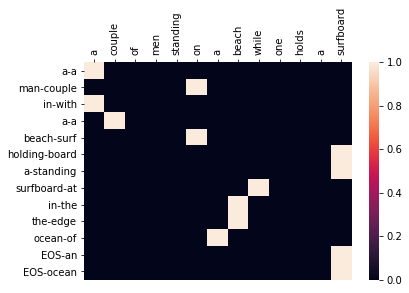

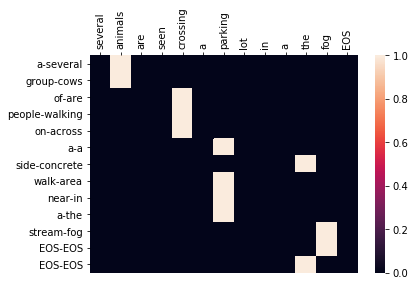

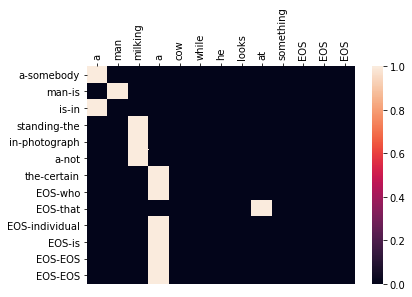

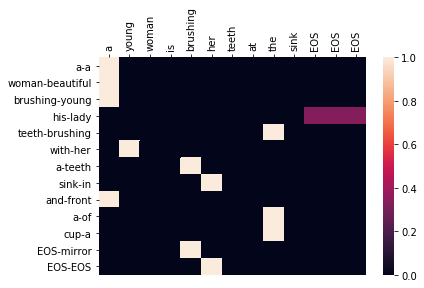

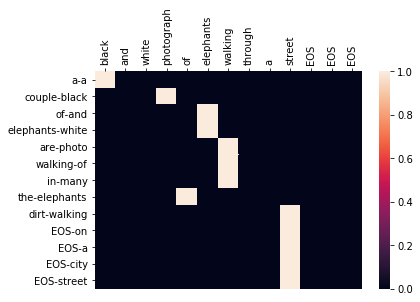



Example 1
INPUT   >> a couple of men standing on a beach while one holds a surfboard
PRED #1 >> a man in a beach holding a surfboard in the ocean
PRED #2 >> a man in a beach with a surfboard in the ocean
PRED #3 >> a man in a beach holding a surfboard ocean the ocean
TRUE    >> a couple with a surf board standing at the edge of an ocean
[BLEU] 0.04

Example 2
INPUT   >> several animals are seen crossing a parking lot in a the fog
PRED #1 >> a group of people on a side walk near a stream
PRED #2 >> a herd of people on a side walk near a stream
PRED #3 >> a group of people on a with walk near a stream
TRUE    >> several cows are walking across a concrete area in the fog
[BLEU] 0.04

Example 3
INPUT   >> a man milking a cow while he looks at something
PRED #1 >> a man is standing in a the
PRED #2 >> a man is standing in the the
PRED #3 >> a man in standing in a the
TRUE    >> somebody is in the photograph not certain who that individual is
[BLEU] 0.05

Example 4
INPUT   >> a young woman

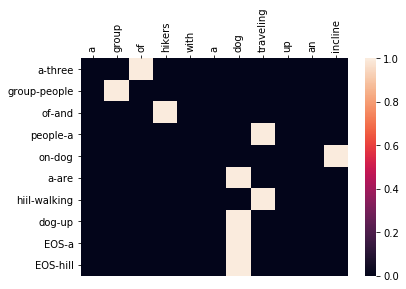

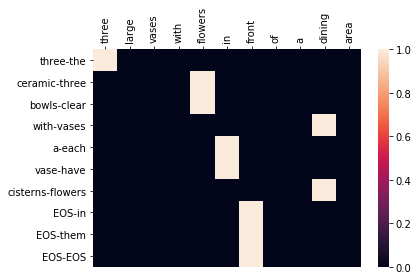

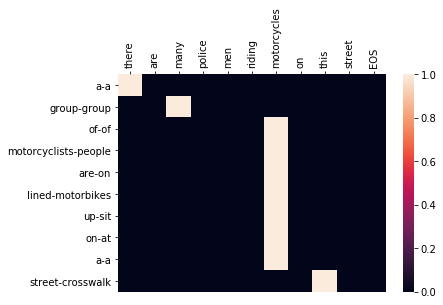

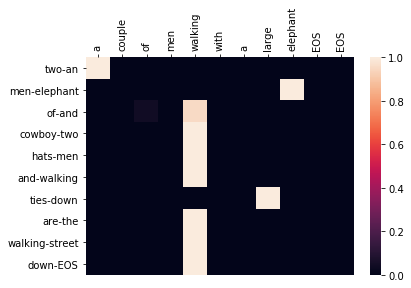

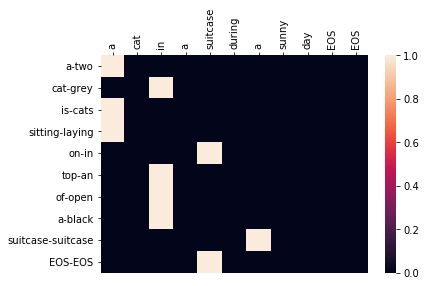



Example 1
INPUT   >> a group of hikers with a dog traveling up an incline
PRED #1 >> a group of people on a hiil dog
PRED #2 >> a group of people riding a hiil dog
PRED #3 >> a group of people on a snowy dog
TRUE    >> three people and a dog are walking up a hill
[BLEU] 0.06

Example 2
INPUT   >> three large vases with flowers in front of a dining area
PRED #1 >> three ceramic bowls with a vase cisterns
PRED #2 >> three ceramic bowls are a vase cisterns
PRED #3 >> a ceramic bowls with a vase cisterns
TRUE    >> the three clear vases each have flowers in them
[BLEU] 0.05

Example 3
INPUT   >> there are many police men riding motorcycles on this street
PRED #1 >> a group of motorcyclists are lined up on a street
PRED #2 >> a group of motorcyclists are lined up by a street
PRED #3 >> a group of motorcyclists are lined up on a road
TRUE    >> a group of people on motorbikes sit at a crosswalk
[BLEU] 0.18

Example 4
INPUT   >> a couple of men walking with a large elephant
PRED #1 >> two m

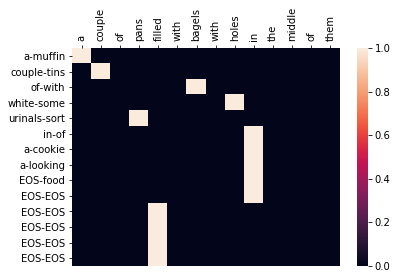

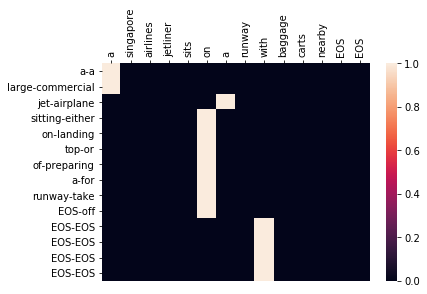

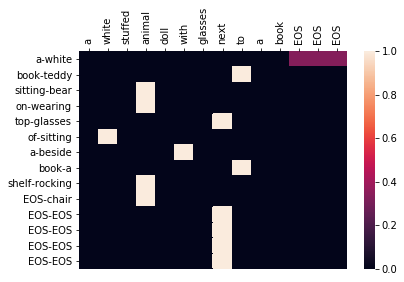

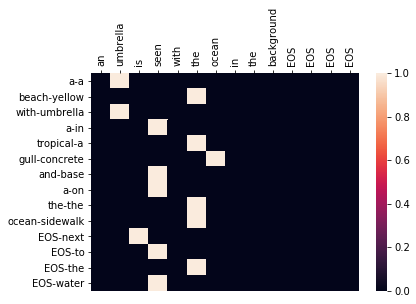

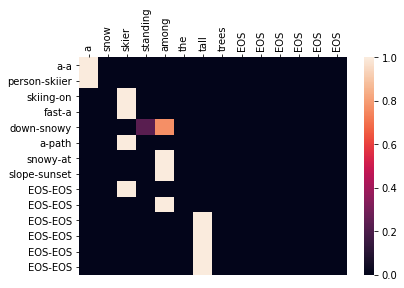



Example 1
INPUT   >> a couple of pans filled with bagels with holes in the middle of them
PRED #1 >> a couple of white urinals in a a
PRED #2 >> a couple of white and in a a
PRED #3 >> a couple of white urinals in a room
TRUE    >> muffin tins with some sort of cookie looking food
[BLEU] 0.05

Example 2
INPUT   >> a singapore airlines jetliner sits on a runway with baggage carts nearby
PRED #1 >> a large jet sitting on top of a runway
PRED #2 >> a large jet sitting on top of a tarmac
PRED #3 >> a private jet sitting on top of a runway
TRUE    >> a commercial airplane either landing or preparing for take off
[BLEU] 0.04

Example 3
INPUT   >> a white stuffed animal doll with glasses next to a book
PRED #1 >> a book sitting on top of a book shelf
PRED #2 >> a book sitting on top of a book
PRED #3 >> a book sitting on top of a desk shelf
TRUE    >> white teddy bear wearing glasses sitting beside a rocking chair
[BLEU] 0.05

Example 4
INPUT   >> an umbrella is seen with the ocean in the b

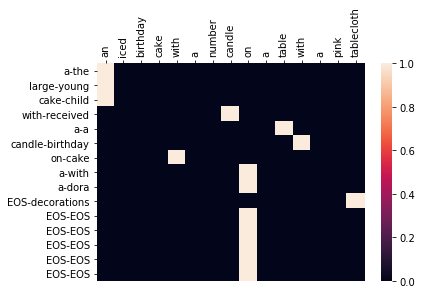

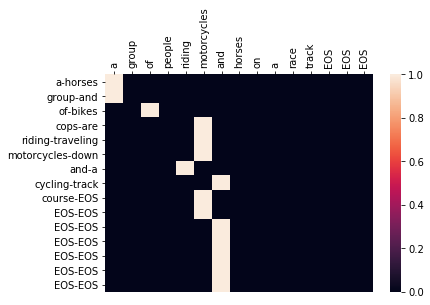

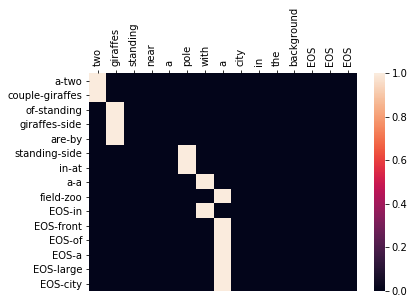

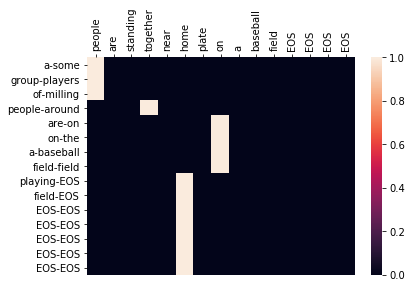

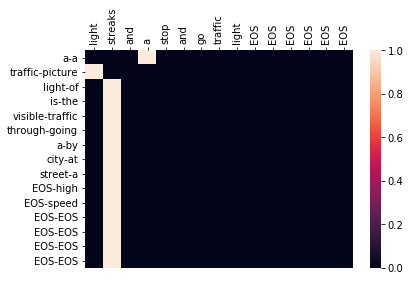



Example 1
INPUT   >> an iced birthday cake with a number candle on a table with a pink tablecloth
PRED #1 >> a large cake with a candle on a a
PRED #2 >> a large cake is a candle on a a
PRED #3 >> a large cake with a candle on a
TRUE    >> the young child received a birthday cake with dora decorations
[BLEU] 0.09

Example 2
INPUT   >> a group of people riding motorcycles and horses on a race track
PRED #1 >> a group of cops riding motorcycles and cycling course
PRED #2 >> a group of cops riding motorcycles and horses course
PRED #3 >> a group of cops riding motorcycles and a course
TRUE    >> horses and bikes are traveling down a track
[BLEU] 0.06

Example 3
INPUT   >> two giraffes standing near a pole with a city in the background
PRED #1 >> a couple of giraffes are standing in a field
PRED #2 >> two couple of giraffes are standing in a field
PRED #3 >> a couple of giraffes are walking in a field
TRUE    >> two giraffes standing side by side at a zoo in front of a large city
[BLEU] 

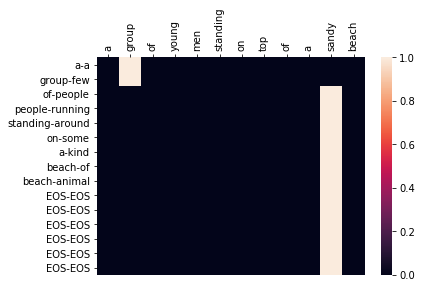

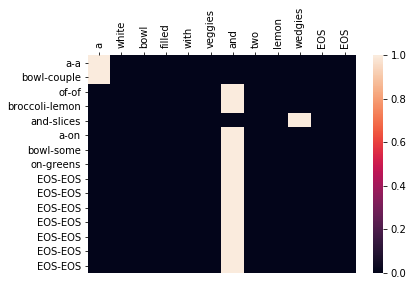

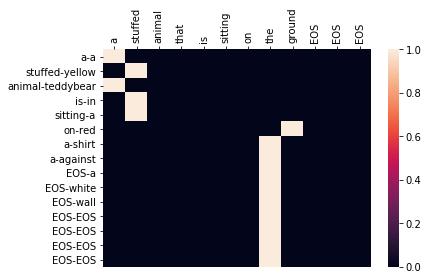

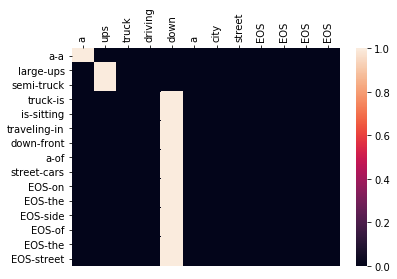

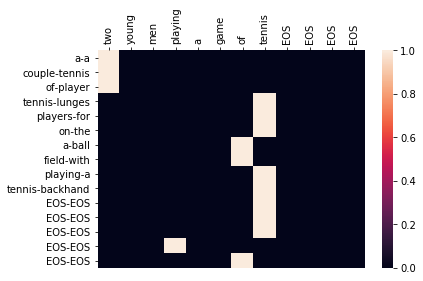



Example 1
INPUT   >> a group of young men standing on top of a sandy beach
PRED #1 >> a group of people standing on a beach beach
PRED #2 >> a group of people standing on a beach holding
PRED #3 >> a group of people standing on a beach playing
TRUE    >> a few people running around some kind of animal
[BLEU] 0.06

Example 2
INPUT   >> a white bowl filled with veggies and two lemon wedgies
PRED #1 >> a bowl of broccoli and a bowl on
PRED #2 >> a bowl of mixed and a bowl on
PRED #3 >> a bowl of broccoli and a bowl of
TRUE    >> a couple of lemon slices on some greens
[BLEU] 0.07

Example 3
INPUT   >> a stuffed animal that is sitting on the ground
PRED #1 >> a stuffed animal is sitting on a a
PRED #2 >> a stuffed animal is on on a a
PRED #3 >> a stuffed animal is sitting on a a a
TRUE    >> a yellow teddybear in a red shirt against a white wall
[BLEU] 0.05

Example 4
INPUT   >> a ups truck driving down a city street
PRED #1 >> a large semi truck is traveling down a street
PRED #2 >> a l

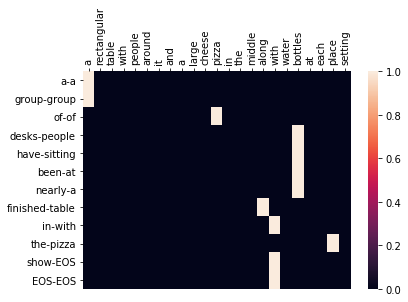

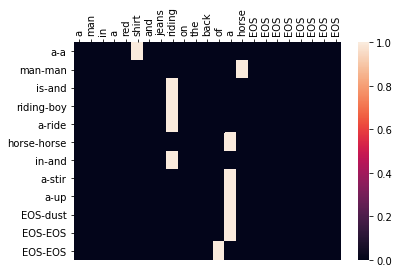

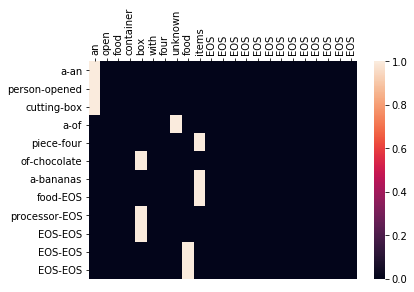

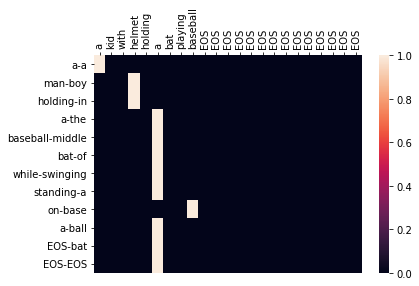

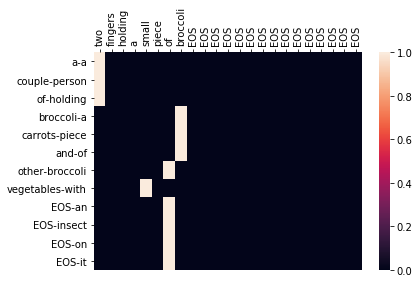



Example 1
INPUT   >> a rectangular table with people around it and a large cheese pizza in the middle along with water bottles at each place setting
PRED #1 >> a group of desks have been nearly finished in the show
PRED #2 >> a group of desks have been nearly finished the show
PRED #3 >> a group of desks sit been nearly finished in the show
TRUE    >> a group of people sitting at a table with pizza
[BLEU] 0.14

Example 2
INPUT   >> a man in a red shirt and jeans riding on the back of a horse
PRED #1 >> a man is riding a horse in a a
PRED #2 >> a man in riding a horse in a a
PRED #3 >> a man is riding a horse a a a
TRUE    >> a man and boy ride horse and stir up dust
[BLEU] 0.09

Example 3
INPUT   >> an open food container box with four unknown food items
PRED #1 >> a person cutting a piece of a food processor
PRED #2 >> a bagged cutting a piece of a food processor
PRED #3 >> a person cutting a piece of carrots food processor
TRUE    >> an opened box of four chocolate bananas
[BLEU] 0

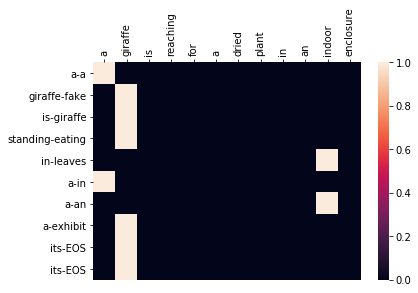

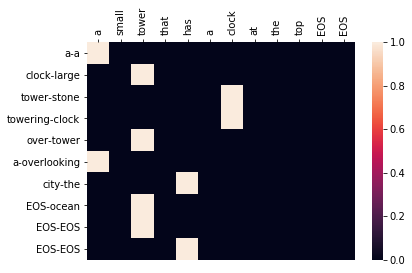

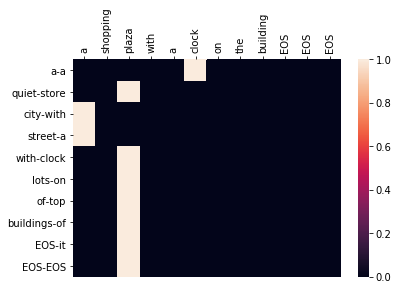

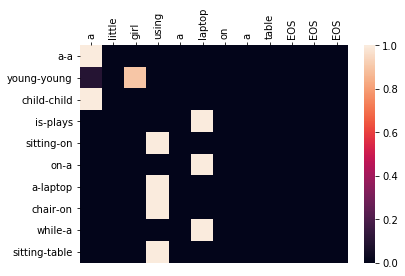

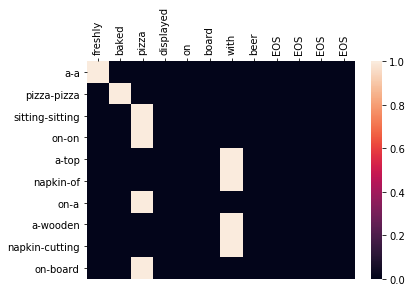



Example 1
INPUT   >> a giraffe is reaching for a dried plant in an indoor enclosure
PRED #1 >> a giraffe is standing in a a a its its
PRED #2 >> a giraffe is standing on a a a its its
PRED #3 >> a giraffe is standing in a a a its
TRUE    >> a fake giraffe eating leaves in an exhibit
[BLEU] 0.06

Example 2
INPUT   >> a small tower that has a clock at the top
PRED #1 >> a clock tower towering over a city
PRED #2 >> a clock tower towering over the city
PRED #3 >> a large tower towering over a city
TRUE    >> a large stone clock tower overlooking the ocean
[BLEU] 0.13

Example 3
INPUT   >> a shopping plaza with a clock on the building
PRED #1 >> a quiet city street with lots of buildings
PRED #2 >> a quiet city street with lots of buildings and
PRED #3 >> a clock city street with lots of buildings
TRUE    >> a store with a clock on top of it
[BLEU] 0.06

Example 4
INPUT   >> a little girl using a laptop on a table
PRED #1 >> a young child is sitting on a chair while sitting
PRED #2 >> a 

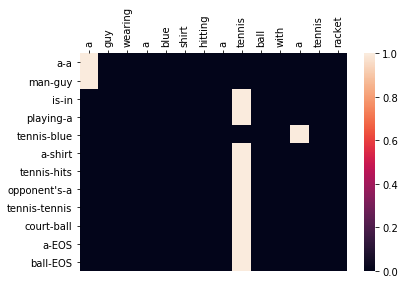

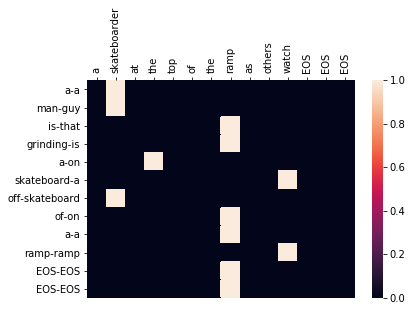

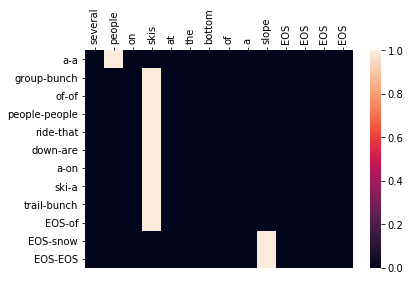

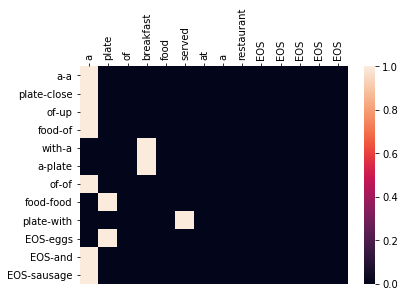

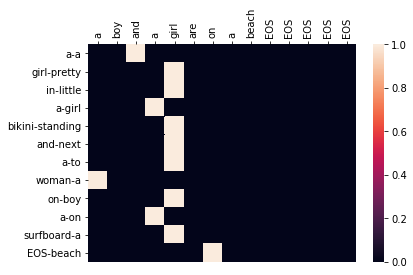



Example 1
INPUT   >> a guy wearing a blue shirt hitting a tennis ball with a tennis racket
PRED #1 >> a man is playing tennis a tennis opponent's tennis court a ball
PRED #2 >> a man is playing tennis a a opponent's tennis court a ball
PRED #3 >> a man is playing tennis on tennis opponent's tennis court a ball
TRUE    >> a guy in a blue shirt hits a tennis ball
[BLEU] 0.09

Example 2
INPUT   >> a skateboarder at the top of the ramp as others watch
PRED #1 >> a man is grinding a skateboard off of a ramp
PRED #2 >> a man in grinding a skateboard off of a ramp
PRED #3 >> a man is grinding on skateboard off of a ramp
TRUE    >> a guy that is on a skateboard on a ramp
[BLEU] 0.13

Example 3
INPUT   >> several people on skis at the bottom of a slope
PRED #1 >> a group of people ride down a ski trail
PRED #2 >> a group of people standing down a ski trail
PRED #3 >> a group of people ride down a snow trail
TRUE    >> a bunch of people that are on a bunch of snow
[BLEU] 0.09

Example 4
INPUT 

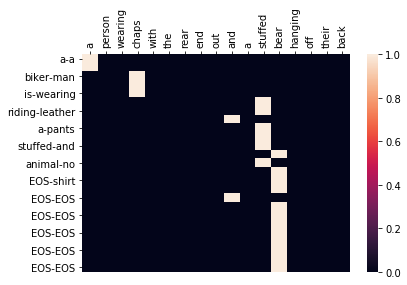

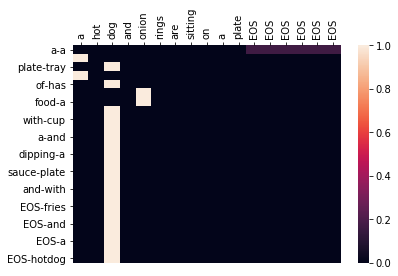

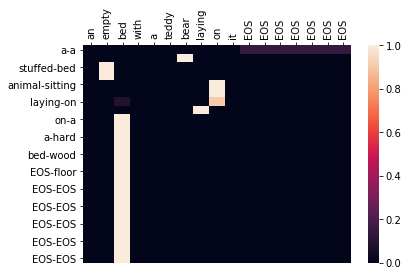

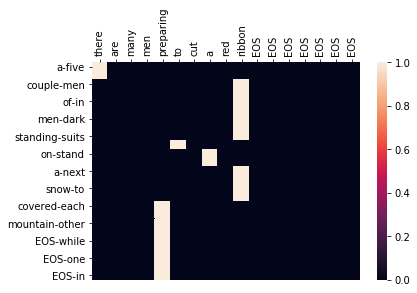

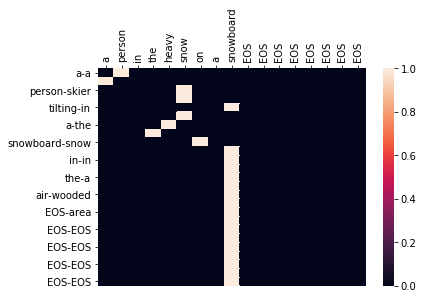



Example 1
INPUT   >> a person wearing chaps with the rear end out and a stuffed bear hanging off their back
PRED #1 >> a biker is riding a stuffed animal
PRED #2 >> a biker is riding a stuffed animal in
PRED #3 >> a biker is standing a stuffed animal
TRUE    >> a man wearing leather pants and no shirt
[BLEU] 0.06

Example 2
INPUT   >> a hot dog and onion rings are sitting on a plate
PRED #1 >> a plate of food with a dipping sauce and
PRED #2 >> a plate of hot with a dipping sauce and
PRED #3 >> a plate of with with a dipping sauce and
TRUE    >> a tray has a cup and a plate with fries and a hotdog on it
[BLEU] 0.06

Example 3
INPUT   >> an empty bed with a teddy bear laying on it
PRED #1 >> a stuffed animal laying on a bed
PRED #2 >> a stuffed animal with on a bed
PRED #3 >> a stuffed animal sitting on a bed
TRUE    >> a bed sitting on a hard wood floor
[BLEU] 0.16

Example 4
INPUT   >> there are many men preparing to cut a red ribbon
PRED #1 >> a couple of men standing on a snow cov

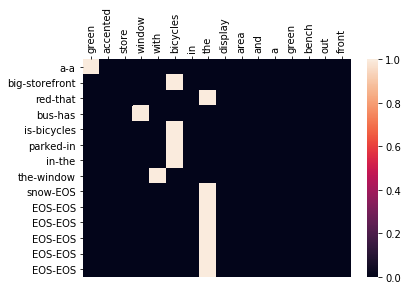

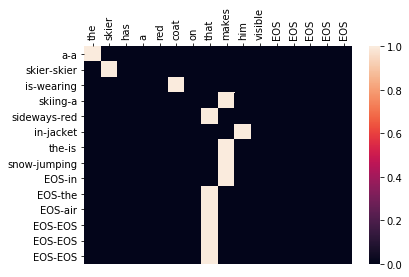

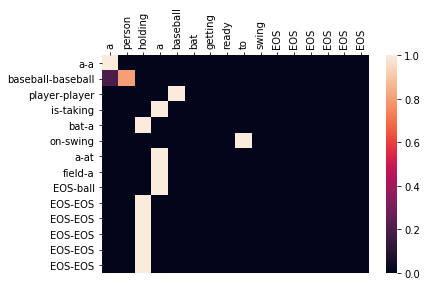

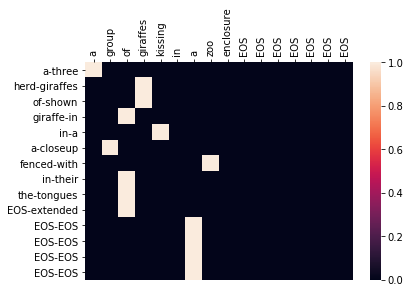

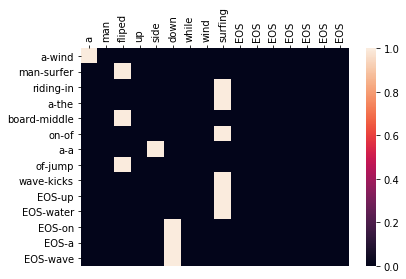



Example 1
INPUT   >> green accented store window with bicycles in the display area and a green bench out front
PRED #1 >> a big red bus is parked in the snow
PRED #2 >> a truck red bus is parked in the snow
PRED #3 >> a small red bus is parked in the snow
TRUE    >> a storefront that has bicycles in the window
[BLEU] 0.11

Example 2
INPUT   >> the skier has a red coat on that makes him visible
PRED #1 >> a skier is skiing sideways in the snow
PRED #2 >> a skier is wearing sideways in the snow
PRED #3 >> a skier is skiing sideways on the snow
TRUE    >> a skier wearing a red jacket is jumping in the air
[BLEU] 0.11

Example 3
INPUT   >> a person holding a baseball bat getting ready to swing
PRED #1 >> a baseball player is bat on a field
PRED #2 >> a baseball player is bat at a field
PRED #3 >> a baseball player is bat on the field
TRUE    >> a baseball player taking a swing at a ball
[BLEU] 0.19

Example 4
INPUT   >> a group of giraffes kissing in a zoo enclosure
PRED #1 >> a herd of 

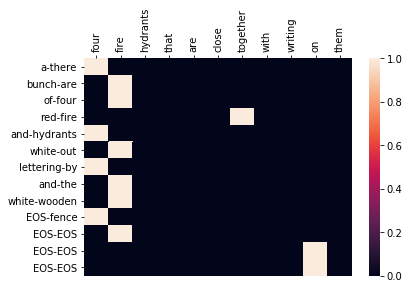

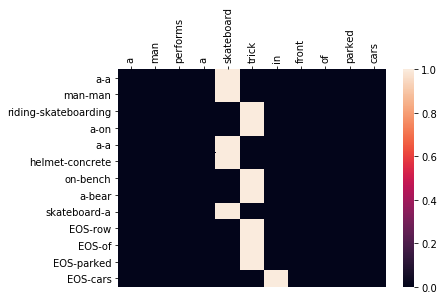

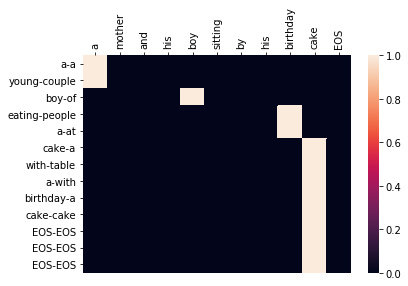

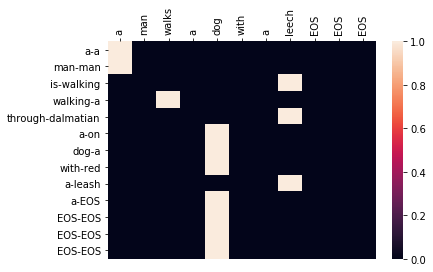

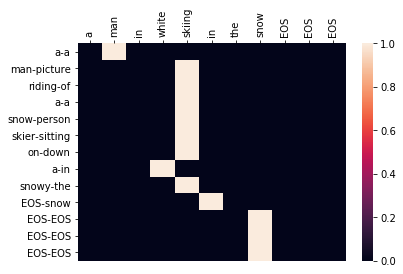



Example 1
INPUT   >> four fire hydrants that are close together with writing on them
PRED #1 >> a bunch of red and white lettering and white
PRED #2 >> a bunch of red and white lettering sitting white
PRED #3 >> a bunch of red and white lettering are white
TRUE    >> there are four fire hydrants out by the wooden fence
[BLEU] 0.00

Example 2
INPUT   >> a man performs a skateboard trick in front of parked cars
PRED #1 >> a man riding a a helmet on a skateboard
PRED #2 >> a man riding a skateboard helmet on a skateboard
PRED #3 >> a man riding a a helmet on a a
TRUE    >> a man skateboarding on a concrete bench bear a row of parked cars
[BLEU] 0.09

Example 3
INPUT   >> a mother and his boy sitting by his birthday cake
PRED #1 >> a young boy eating a cake with a birthday cake
PRED #2 >> a man boy eating a cake with a birthday cake
PRED #3 >> a young boy eating a cake a a birthday cake
TRUE    >> a couple of people at a table with a cake
[BLEU] 0.13

Example 4
INPUT   >> a man walks a d

In [129]:
s2s = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens,
              attentionType='luong',
              batchSize=32, embeddingSize=300, hiddenSize=512,
              beamSize=3,
              nLayers=2, dropout=0.1, residual=True, bidirectional=True,
              lr=1e-3, enforcingRatio=0.8, clip=20.0, gloveInit=embeddings)
s2s.train(nEpochs=50, epochSize=1000, printEvery=50, evalSize=5)
s2s.evaluate(nBatches=50, saveResults=True, resultBeamSize=1) # otherwise it gon be slow.
torch.save(s2s, 'mscoco/seq2seq-beam-test.ckpt')